In [540]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pandas.api.types import is_numeric_dtype

In [541]:
!pip install tensorflow

In [542]:
import tensorflow as tf

In [543]:
!pip install keras

In [544]:
!pip install scikeras

In [545]:
import keras
from keras.layers import Input
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
# from keras.layers import Flatten
# from keras.layers.convolutional import Conv1D
# from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [546]:
import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [547]:
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

In [548]:
!pip install shap
import shap

In [549]:
from google.cloud import bigquery

---------

### Authentication for working from Google Colab

In [550]:
# from google.colab import auth
# auth.authenticate_user()

---------

### Destination to save trained models

#### Google disk

In [551]:
# from google.colab import drive

# drive.mount('/content/gdrive')
# project_folder_path = '/content/gdrive/Shareddrives/Magisterka/PROJEKT/'
# models_path = project_folder_path + '/models'

#### Vertex AI Jupyter Lab

In [552]:
data_analysis_folder_path = '../'
models_path = data_analysis_folder_path + '/models'

---------

### Connect to Bigquery service

In [553]:
project_id = "master-thesis-2023-393813" # Fill project id
bqclient = bigquery.Client(project_id)

## Loading data

In [554]:
dataset_name = "twitbot_22_preprocessed_common_users_ids" #"twitbot_22_preprocessed"
users_table_name = "users"
BQ_TABLE_USERS = dataset_name + "." + users_table_name
table_id = project_id + "." + BQ_TABLE_USERS

In [555]:
job_config = bigquery.QueryJobConfig(
    allow_large_results=True, destination=table_id, use_legacy_sql=True
)

In [556]:
# SQL_QUERY = f"""SELECT * FROM {BQ_TABLE_USERS} LIMIT 1000"""
# users_df1 = bqclient.query(SQL_QUERY).to_dataframe()

In [557]:
SQL_QUERY = f"""WITH 
  human_records AS (
    SELECT *, ROW_NUMBER() OVER () row_num 
    FROM {BQ_TABLE_USERS}
    WHERE label = 'human' 
    LIMIT 500),
  bot_records AS (
  SELECT *, ROW_NUMBER() OVER () row_num 
    FROM {BQ_TABLE_USERS}
    WHERE label = 'bot' 
    LIMIT 500)
  SELECT * FROM human_records 
    UNION ALL SELECT * 
    FROM bot_records 
    ORDER BY row_num;"""

users_df1 = bqclient.query(SQL_QUERY).to_dataframe()
users_df1 = users_df1.drop(['row_num'], axis=1)

In [558]:
# LIMIT RESULTS OPTIONS
pd.set_option('display.max_rows', 100)
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_column', None)
pd.set_option('display.max_colwidth', None)

In [559]:
num_bots = len(users_df1.loc[users_df1['label']=='bot'])       # bots number
num_humans = len(users_df1.loc[users_df1['label']=='human'])   # humans number

print("Number of real users: ", num_humans)
print("Number of bots: ", num_bots)

Number of real users:  500
Number of bots:  500


In [560]:
org_users_df = pd.DataFrame(users_df1).copy()
users_df2 = pd.DataFrame(org_users_df).copy()

#### Filter to have same number of record for each class - part I (second part after data analysis and reducing some of outliers)

In [561]:
def filter_df_for_balanced_classes(df, bot_label_value='bot', human_label_value='human'):
    new_df = pd.DataFrame()

    i = 0 # bots iter.
    j = 0 # humans iter.
    k = 0
    num_bots = len(df.loc[df['label']==bot_label_value])
    num_humans = len(df.loc[df['label']==human_label_value])
    max_num = min(num_bots, num_humans)
    for index, record in df.iterrows():
      if k < (2*max_num):
        if record['label']==bot_label_value and i < max_num:
          new_df = new_df.append(record)
          # users_df = pd.concat([users_df, record], ignore_index=True)
          i += 1
          k += 1
        if record['label']==human_label_value and j < max_num:
          new_df = new_df.append(record)
          # users_df = pd.concat([users_df, record], ignore_index=True)
          j += 1
          k += 1
            
    print("Number of bots: ", len(new_df.loc[new_df['label']==bot_label_value]))
    print("Number of human users: ", len(new_df.loc[new_df['label']==human_label_value]))
    
    return pd.DataFrame(new_df).copy();

In [562]:
users_df = filter_df_for_balanced_classes(users_df2)

Number of bots:  500
Number of human users:  500


## Data preparation

In [563]:
def drop_columns(df, columns):
    for column_name in columns:
      df = df.drop([column_name], axis=1)
    return df

In [564]:
def encode_not_numeric_columns(df):
  for column_name in df:
    if not is_numeric_dtype(df[column_name]):
      unique_values_dict = dict(enumerate(df[column_name].unique()))
      unique_values_dict = dict((v, k) for k, v in unique_values_dict.items())
      df[column_name] = df[column_name].map(unique_values_dict)
  return df

#### Align values for bool columns

In [565]:
boolean_columns = ["verified", "protected", "withheld", "has_location", "has_profile_image_url", "has_pinned_tweet", "has_description"]

In [566]:
# Firstly align boolean columns values
for col_name in boolean_columns:
    users_df[col_name] = users_df[col_name].astype(bool)

column_to_remove = []
# Check unique values (some of subset can have only one unique value for some feature) if so it column will be removed from dataframe
for col_name in boolean_columns:
    uniq_val_list = users_df[col_name].unique()
    print("Column {:<24} {}".format(col_name, str(uniq_val_list)))
    if (len(uniq_val_list) < 2):
        column_to_remove.append(col_name)

Column verified                 [False  True]
Column protected                [False  True]
Column withheld                 [False]
Column has_location             [ True False]
Column has_profile_image_url    [ True]
Column has_pinned_tweet         [False  True]
Column has_description          [ True False]


In [567]:
column_to_remove

['withheld', 'has_profile_image_url']

In [568]:
# remove from bool columns:
for col_name in column_to_remove:
    boolean_columns.remove(col_name)
# remove from dataframe
users_df = drop_columns(users_df, column_to_remove)

### Encoding of non-numeric information which will be used by model

In [569]:
# Remap the values of the dataframe
for col_name in boolean_columns:
  users_df[col_name] = users_df[col_name].map({True:1,False:0})

# Remap label values human/bot for 0/1
label_col = "label"
users_df[label_col] = users_df[label_col].map({"human":0,"bot":1})


In [570]:
users_df

id  label         username  \
0    1428769922507751429      1  BotoxAesthetics   
1    1484544053572419585      0  blessing_xettry   
2     842202106324951040      1     Mark11474609   
3    1447956502443069446      0      menametaken   
4               21309002      1          Sjouzan   
..                   ...    ...              ...   
995           2478834780      0   respectjamaica   
996  1481547983510552578      1  Nwachuk44285848   
997             22693193      0     KStewartUtah   
998  1061559864239910912      1     Moral_Tomato   
999             60678884      0      MikeHoltNEC   

                               name    created_at  verified  protected  \
0    dermalfillers Aesthetics botox  1.629480e+09         0          0   
1                  #Blessing xettry  1.642778e+09         0          0   
2                              Mark  1.489632e+09         0          0   
3                         winwinnie  1.634055e+09         0          0   
4                            Zuzana  1.235058e+09         0          0   
..                              ...           ...       ...        ...   
995                 Respect Jamaica  1.399324e+09         0          0   
996             Nwachukwu Ugochukwu  1.642064e+09         0          0   
997                 Kirsten Stewart  1.236120e+09         0          0   
998                           Brian  1.541931e+09         0          0   
999                       Mike Holt  1.248721e+09         0          0   

     has_location                 location  has_pinned_tweet  \
0               1  London , United Kingdom                 0   
1               1                    Nepal                 0   
2               1   Kelvin Grove, Brisbane                 0   
3               1               your walls                 0   
4               1             Brighton, UK                 0   
..            ...                      ...               ...   
995             1                  Jamaica                 0   
996             0                     None                 0   
997             1                  SLC, UT                 0   
998             0                     None                 0   
999             1        Leesburg, Florida                 0   

                         url  followers_count  following_count  tweet_count  \
0    https://t.co/CBDBvXnRKv              2.0             41.0          1.0   
1                                         0.0             24.0          1.0   
2                                         3.0             22.0          4.0   
3                                         0.0             20.0          1.0   
4                                         3.0             42.0          2.0   
..                       ...              ...              ...          ...   
995  https://t.co/XWnVzl5h5M           2546.0            559.0       7995.0   
996                                       0.0             10.0         10.0   
997                                    2036.0            934.0       9187.0   
998                                       0.0            132.0         15.0   
999   http://t.co/jnNPcg1vGc           3316.0              1.0       2280.0   

     listed_count  has_description  \
0             0.0                1   
1             0.0                1   
2             0.0                0   
3             0.0                1   
4             0.0                0   
..            ...              ...   
995          40.0                1   
996           0.0                0   
997         135.0                1   
998           0.0                0   
999          49.0                1   

                                                                                                                                                          description  \
0    Enhance fillers is a progressive company found in the city of Webminster,We offer a wide range of aesthetic services including Botox, Dysport, Xeomin,the Juved

#### Null and NaN statistics

In [571]:
for col_name in users_df:
    count1 = pd.isnull(users_df[col_name]).sum()
    print(col_name + ": " + str(count1))

id: 0
label: 0
username: 0
name: 0
created_at: 0
verified: 0
protected: 0
has_location: 0
location: 194
has_pinned_tweet: 0
url: 0
followers_count: 0
following_count: 0
tweet_count: 0
listed_count: 0
has_description: 0
description: 0
descr_no_hashtags: 0
descr_no_cashtags: 0
descr_no_mentions: 0
descr_no_urls: 0
url_no_urls: 0


#### Extract some information from dataframe to new columns

##### Description length

In [572]:
users_df['descr_len'] = users_df['description'].apply(len).astype(float)

##### Account age (in days) (sice 16.03.2022) (dataset data collected during the 20/01-15/03/2022 period)

In [573]:
from datetime import datetime

In [574]:
def cal_days_diff(a,b):
    A = a.replace(hour = 0, minute = 0, second = 0, microsecond = 0)
    B = b.replace(hour = 0, minute = 0, second = 0, microsecond = 0)
    return (A - B).days

def convert_unixtime_to_datetime(a):
    return datetime.utcfromtimestamp(a)

In [575]:
base_date = datetime(2022, 3, 16)
users_df['account_age'] = users_df.apply(lambda x: cal_days_diff(base_date, convert_unixtime_to_datetime(x.created_at)), axis=1).astype(float)

#### Reduce unnecessary columns

In [576]:
users_reduced_df = pd.DataFrame(users_df).copy()
# columns_to_drop = ["id", "username", "name", "created_at", "location", "url", "description"]
columns_to_drop = ["username", "name", "created_at", "location", "url", "description"]
users_reduced_df = drop_columns(users_reduced_df, columns_to_drop)
users_reduced_df

id  label  verified  protected  has_location  \
0    1428769922507751429      1         0          0             1   
1    1484544053572419585      0         0          0             1   
2     842202106324951040      1         0          0             1   
3    1447956502443069446      0         0          0             1   
4               21309002      1         0          0             1   
..                   ...    ...       ...        ...           ...   
995           2478834780      0         0          0             1   
996  1481547983510552578      1         0          0             0   
997             22693193      0         0          0             1   
998  1061559864239910912      1         0          0             0   
999             60678884      0         0          0             1   

     has_pinned_tweet  followers_count  following_count  tweet_count  \
0                   0              2.0             41.0          1.0   
1                   0              0.0             24.0          1.0   
2                   0              3.0             22.0          4.0   
3                   0              0.0             20.0          1.0   
4                   0              3.0             42.0          2.0   
..                ...              ...              ...          ...   
995                 0           2546.0            559.0       7995.0   
996                 0              0.0             10.0         10.0   
997                 0           2036.0            934.0       9187.0   
998                 0              0.0            132.0         15.0   
999                 0           3316.0              1.0       2280.0   

     listed_count  has_description  descr_no_hashtags  descr_no_cashtags  \
0             0.0                1                0.0                0.0   
1             0.0                1                0.0                0.0   
2             0.0                0                0.0                0.0   
3             0.0                1                1.0                0.0   
4             0.0                0                0.0                0.0   
..            ...              ...                ...                ...   
995          40.0                1                0.0                0.0   
996           0.0                0                0.0                0.0   
997         135.0                1                0.0                0.0   
998           0.0                0                0.0                0.0   
999          49.0                1                0.0                0.0   

     descr_no_mentions  descr_no_urls  url_no_urls  descr_len  account_age  
0                  0.0            0.0          1.0      160.0        208.0  
1                  0.0            0.0          0.0       72.0         54.0  
2                  0.0            0.0          0.0        0.0       1826.0  
3                  0.0            0.0          0.0       85.0        155.0  
4                  0.0            0.0          0.0        0.0       4773.0  
..                 ...            ...          ...        ...          ...  
995                0.0            0.0          1.0      114.0       2872.0  
996                0.0            0.0          0.0        0.0         62.0  
997                0.0            0.0          0.0      152.0       4761.0  
998                0.0            0.0          0.0        0.0       1221.0  
999                0.0            0.0          1.0      160.0       4615.0  

[1000 rows x 18 columns]

### Data type conversion (to float)

In [577]:
for (column_name, column_data) in users_reduced_df.iteritems():
    users_reduced_df[column_name] = users_reduced_df[column_name].astype(float)

### Data split for training, validation and testing

In [578]:
train_data, test_data = train_test_split(users_reduced_df, test_size=0.30, random_state=25, shuffle=True)
test_data, val_data = train_test_split(test_data, test_size=0.5, random_state=25, shuffle=True)

### Create same dataframe for validation and test set to work with based on outliers analysis (done in later part)

In [579]:
val_data_wo_outliers = pd.DataFrame(val_data).copy()
test_data_wo_outliers = pd.DataFrame(test_data).copy()

### Describe trainig dataset

In [580]:
train_data.describe()

id       label    verified   protected  has_location  \
count  7.000000e+02  700.000000  700.000000  700.000000    700.000000   
mean   4.803014e+17    0.495714    0.054286    0.005714      0.807143   
std    5.830958e+17    0.500339    0.226743    0.075431      0.394824   
min    7.608920e+05    0.000000    0.000000    0.000000      0.000000   
25%    2.199551e+08    0.000000    0.000000    0.000000      1.000000   
50%    2.900489e+09    0.000000    0.000000    0.000000      1.000000   
75%    1.095899e+18    1.000000    0.000000    0.000000      1.000000   
max    1.487790e+18    1.000000    1.000000    1.000000      1.000000   

       has_pinned_tweet  followers_count  following_count    tweet_count  \
count        700.000000     7.000000e+02       700.000000     700.000000   
mean           0.215714     8.664703e+03      1772.891429    8470.495714   
std            0.411611     7.181831e+04     10480.792222   40030.878990   
min            0.000000     0.000000e+00         0.000000       0.000000   
25%            0.000000     4.675000e+01        73.750000      46.750000   
50%            0.000000     2.715000e+02       289.000000     732.500000   
75%            0.000000     1.489000e+03       975.500000    4677.750000   
max            1.000000     1.730667e+06    244195.000000  787615.000000   

       listed_count  has_description  descr_no_hashtags  descr_no_cashtags  \
count    700.000000       700.000000         700.000000         700.000000   
mean     100.741429         0.815714           0.450000           0.002857   
std      365.485524         0.387994           1.435923           0.053414   
min        0.000000         0.000000           0.000000           0.000000   
25%        0.000000         1.000000           0.000000           0.000000   
50%        4.000000         1.000000           0.000000           0.000000   
75%       44.000000         1.000000           0.000000           0.000000   
max     5818.000000         1.000000          16.000000           1.000000   

       descr_no_mentions  descr_no_urls  url_no_urls   descr_len  account_age  
count         700.000000     700.000000   700.000000  700.000000   700.000000  
mean            0.325714       0.107143     0.602857   87.102857  2645.265714  
std             0.873826       0.394824     0.489656   58.306705  1597.085740  
min             0.000000       0.000000     0.000000    0.000000    45.000000  
25%             0.000000       0.000000     0.000000   31.750000  1126.750000  
50%             0.000000       0.000000     1.000000  100.500000  2665.000000  
75%             0.000000       0.000000     1.000000  142.000000  4127.750000  
max             7.000000       4.000000     1.000000  171.000000  5514.000000

# Data analysis

In [581]:
def get_dataframe_real_indexes(df, outliers_index_list):
    real_all_indexes = train_data.loc[train_data['label']==1].index
    oder_indexes = np.arange(len(real_all_indexes)) 

    indexes_df = pd.DataFrame({'real_index' : real_all_indexes, 'order_index' : oder_indexes})
    return list(indexes_df[indexes_df.order_index.isin(outliers_index_list)]['real_index'])

In [582]:
def outliers_KNN(data, column_name, n_neighbors=10, radius=5, title="", r1=48, r2=90, w=900, h=500, ydtick=2, xdtick=2, nbins=20,  th = 0.9):

    np.set_printoptions(threshold=np.inf)

    # create model
    nbrs = NearestNeighbors(n_neighbors = n_neighbors, radius=radius)
    # fit model
    data_2d = [ [ 0., x] for x in data[column_name].values]
    nbrs.fit(data_2d)

    neighbors_and_distances = nbrs.kneighbors(data_2d)
    distances = neighbors_and_distances[0]
    neighbors = neighbors_and_distances[1]
    # print(neighbors_and_distances[1])

    plt.figure(figsize=(15, 7))
    # plt.plot(distances.mean(axis=1))

    distances = pd.DataFrame(distances)
    distances_mean = pd.DataFrame(distances).mean(axis =1)
    # distances_mean.describe()
    
    outliers_index = np.where(distances_mean > th) 
    outliers_index = list(outliers_index)[0]
    outliers_index = [outliers_index[i] for i in range(len(outliers_index))]
    outliers_index_with_column_name = [[indx, data[column_name].values[indx]] for indx in outliers_index]
    outliers_index_sorted_by_column_name = sorted(outliers_index_with_column_name,key=lambda x: x[1])

    outliers = list(dict(outliers_index_sorted_by_column_name).values())
    outliers_indexes = list(dict(outliers_index_sorted_by_column_name).keys())

    print("Number of outliers: ", len(outliers))

    fig = make_subplots(specs=[[{"secondary_y": True}]])

    trace1 = go.Histogram(
            x=data[column_name],
            name=column_name,
            nbinsx=nbins,
            opacity=0.7,
    )
    trace2 = go.Histogram(
        x=outliers,
        nbinsx=nbins,
        # histnorm='density',
        name='outliers',
        opacity=0.7
    )

    traces = [trace1, trace2]
    layout = go.Layout(barmode='overlay')
    # layout = go.Layout()
    fig = go.Figure(data=traces, layout=layout)
    fig.update_layout(
        title_text=title, # title f plot
        xaxis_title_text='value', # xaxis label
        yaxis_title_text='frequency', # yaxis label
        bargap=0.05,
        bargroupgap=0.05
    )

    # fig.update_xaxes(dtick=xdtick, range =[r1,r2])
    # fig.update_yaxes(dtick=ydtick)
    fig.update_layout(
        width=w,
        height=h)
    fig.show()
    
    return get_dataframe_real_indexes(data, outliers_index)

## Distribution of label class in training, validation and test set

In [583]:
stack_data = {'Set': ['Training data', 'Validation data', 'Test data', 'Training data', 'Validation data', 'Test data'],
              'Label': ['Bot', 'Bot', 'Bot', 'Human', 'Human', 'Human'],
              'Freq': [len(train_data.loc[train_data['label']==1]), 
                       len(val_data.loc[val_data['label']==1]), 
                       len(test_data.loc[test_data['label']==1]),
                       len(train_data.loc[train_data['label']==0]), 
                       len(val_data.loc[val_data['label']==0]), 
                       len(test_data.loc[test_data['label']==0])]}
sdf = pd.DataFrame(stack_data)
sdf

Set  Label  Freq
0    Training data    Bot   347
1  Validation data    Bot    83
2        Test data    Bot    70
3    Training data  Human   353
4  Validation data  Human    67
5        Test data  Human    80

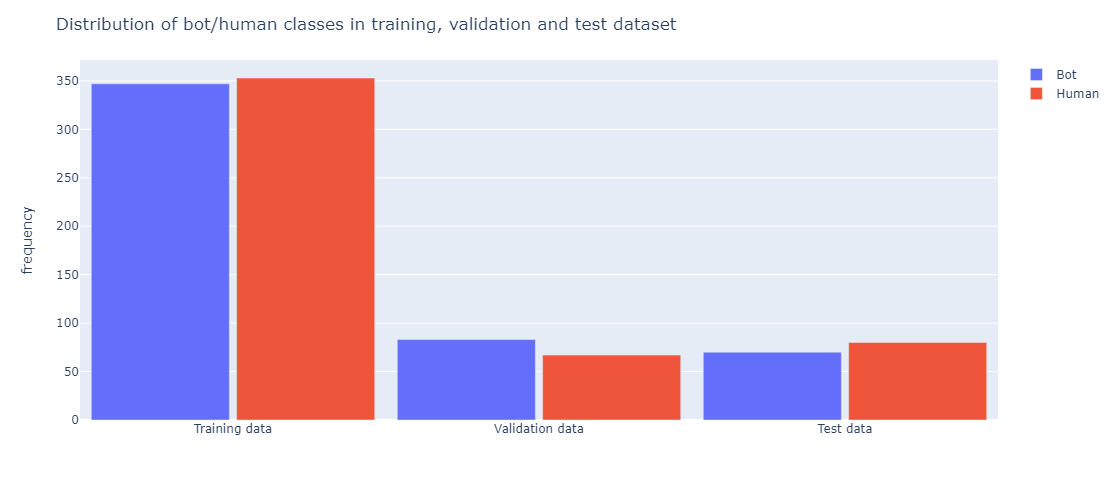

In [584]:
fig = px.bar(sdf, x="Set", y="Freq",
             color="Label", hover_data=['Label'],
             barmode = 'group')
fig.update_layout(
    title_text='Distribution of bot/human classes in training, validation and test dataset',
    xaxis_title_text='', #'subset',
    yaxis_title_text='frequency',
    bargap=0.05,
    bargroupgap=0.05,
    width=700,
    height=500,
    legend={"title":""})
fig.show()

## Distribution of other features in training dataset

### ['verified', 'protected', 'has_location', 'has_profile_image_url', 'has_pinned_tweet', 'has_description']

In [585]:
train_bot_data = train_data.loc[train_data['label']==1]
train_human_data = train_data.loc[train_data['label']==0]

# stack_bool_training_feature_data = {'Feature': ['verified', 'protected', 'has_location', 'has_profile_image_url', 'has_pinned_tweet', 'has_description']*4,
#     'Label': ['Bot']*12 + ['Human']*12,
#     'Value': [True]*6 + [False]*6 + [True]*6 + [False]*6,
stack_bool_training_feature_data = {'Feature': ['verified', 'protected', 'has_location', 'has_pinned_tweet', 'has_description']*4,
    'Label': ['Bot']*10 + ['Human']*10,
    'Value': [True]*5 + [False]*5 + [True]*5 + [False]*5,
    'Freq': [len(train_bot_data.loc[train_bot_data['verified']==1]), 
             len(train_bot_data.loc[train_bot_data['protected']==1]), 
             len(train_bot_data.loc[train_bot_data['has_location']==1]),
             # len(train_bot_data.loc[train_bot_data['has_profile_image_url']==1]), 
             len(train_bot_data.loc[train_bot_data['has_pinned_tweet']==1]), 
             len(train_bot_data.loc[train_bot_data['has_description']==1]),
             len(train_bot_data.loc[train_bot_data['verified']==0]), 
             len(train_bot_data.loc[train_bot_data['protected']==0]), 
             len(train_bot_data.loc[train_bot_data['has_location']==0]),
             # len(train_bot_data.loc[train_bot_data['has_profile_image_url']==0]), 
             len(train_bot_data.loc[train_bot_data['has_pinned_tweet']==0]), 
             len(train_bot_data.loc[train_bot_data['has_description']==0]),
             len(train_human_data.loc[train_human_data['verified']==1]), 
             len(train_human_data.loc[train_human_data['protected']==1]), 
             len(train_human_data.loc[train_human_data['has_location']==1]),
             # len(train_human_data.loc[train_human_data['has_profile_image_url']==1]), 
             len(train_human_data.loc[train_human_data['has_pinned_tweet']==1]), 
             len(train_human_data.loc[train_human_data['has_description']==1]),
             len(train_human_data.loc[train_human_data['verified']==0]), 
             len(train_human_data.loc[train_human_data['protected']==0]), 
             len(train_human_data.loc[train_human_data['has_location']==0]),
             # len(train_human_data.loc[train_human_data['has_profile_image_url']==0]), 
             len(train_human_data.loc[train_human_data['has_pinned_tweet']==0]), 
             len(train_human_data.loc[train_human_data['has_description']==0])]}

stack_training_bool_feature_df = pd.DataFrame(stack_bool_training_feature_data)

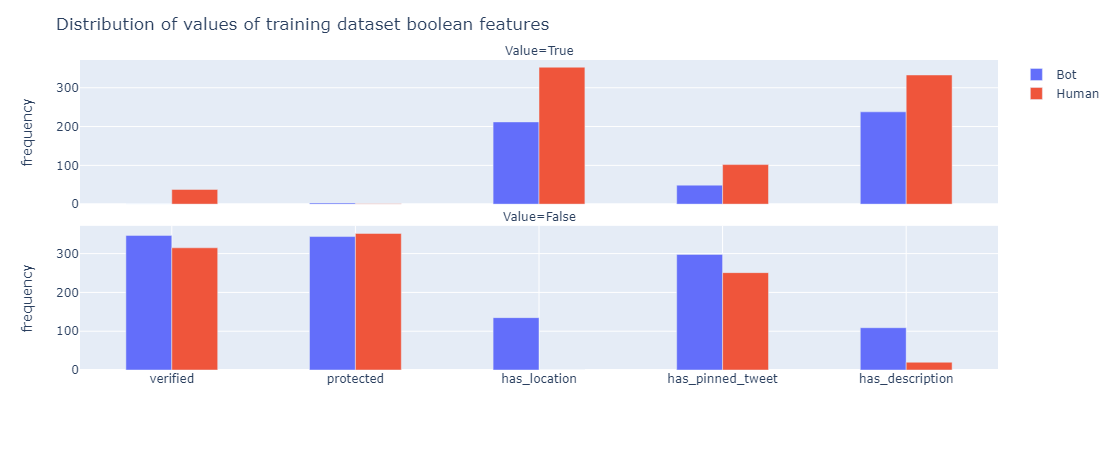

In [586]:
fig = px.bar(stack_training_bool_feature_df, 
               x="Feature", 
               y="Freq",
               facet_col="Value",
               facet_col_wrap = 1,
               color="Label", hover_data=['Label'],
               barmode = 'group')
fig.update_layout(
    title_text='Distribution of values of training dataset boolean features',
    xaxis_title_text='', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True))

fig.update_yaxes(row=2, col=1, title='frequency')
fig.show()

### followers_count

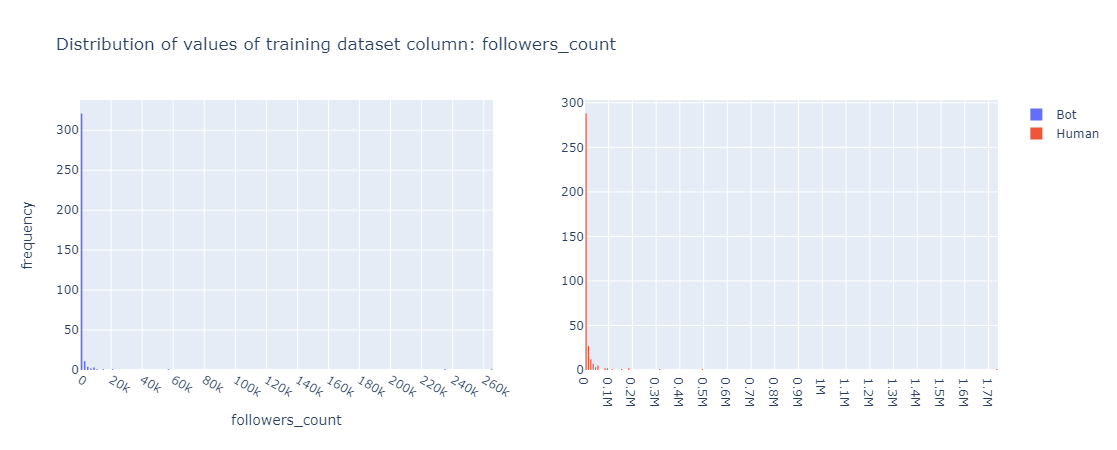

In [587]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'followers_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'followers_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: followers_count',
    xaxis_title_text='followers_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True,title='followers_count', dtick=20000),
    xaxis2=dict(showgrid=True, dtick=100000),
    yaxis=dict(showgrid=True))

fig.show()

#### followers_count - outliers

##### K-means (mnonot useful)

Number of outliers:  105


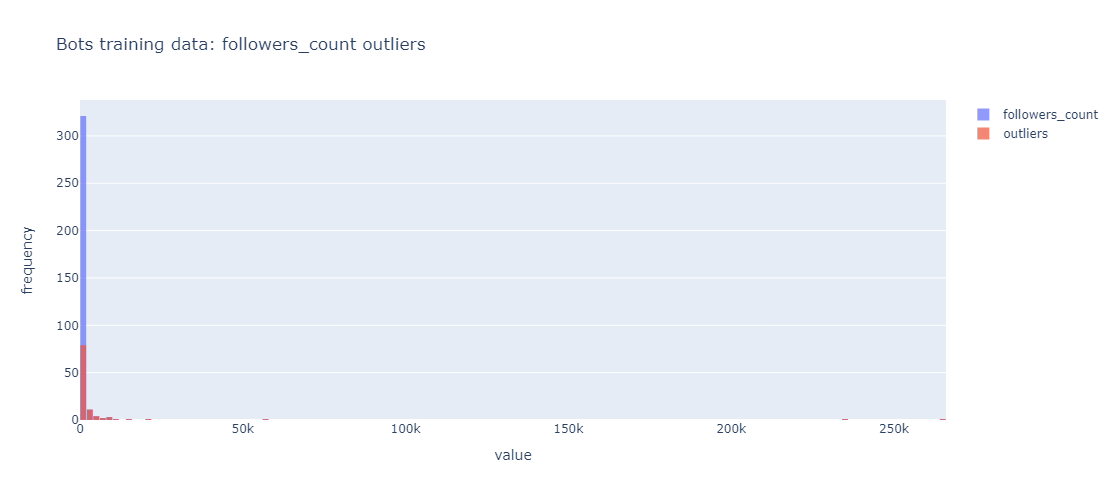

<Figure size 1500x700 with 0 Axes>

In [588]:
followers_count_bots_outliers_indexes = outliers_KNN(train_data.loc[train_data['label']==1], 'followers_count', title = "Bots training data: followers_count outliers", n_neighbors=2, radius=1, nbins=200)

Number of outliers:  255


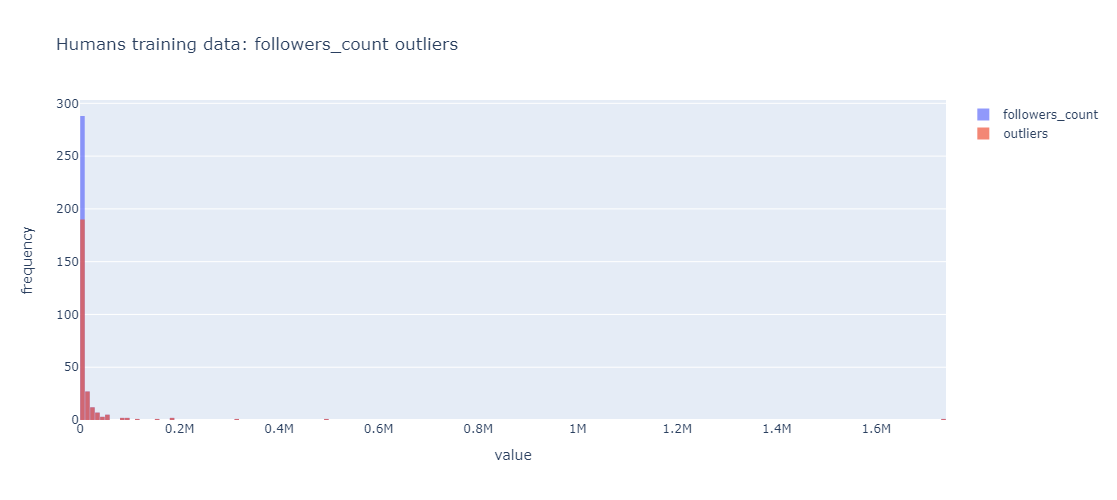

<Figure size 1500x700 with 0 Axes>

In [589]:
followers_count_humans_outliers_indexes = outliers_KNN(train_data.loc[train_data['label']==0], 'followers_count', title = "Humans training data: followers_count outliers", n_neighbors=2, radius=1, nbins=200)

In [590]:
# q_hi_bots = train_data.loc[train_data['label']==1]['followers_count'].quantile(0.99, interpolation='nearest')
# q_hi_humans = train_data.loc[train_data['label']==0]['followers_count'].quantile(0.99, interpolation='nearest')

# df_filtered_bots = train_data.loc[train_data['label']==1][(train_data.loc[train_data['label']==1]['followers_count'] < q_hi_bots)]
# df_filtered_humans = train_data.loc[train_data['label']==0][(train_data.loc[train_data['label']==0]['followers_count'] < q_hi_humans)]

In [591]:
len(train_data[(train_data['label']==1)])

347

In [592]:
len(train_data[(train_data['label']==0)])

353

In [593]:
from scipy.stats import expon

# Fit an exponential distribution to data
loc_b, scale_b = expon.fit(train_data.loc[train_data['label']==1]['followers_count'])
loc_h, scale_h = expon.fit(train_data.loc[train_data['label']==0]['followers_count'])

# Calculate the 99th percentile using the percent-point function (inverse CDF)
percentile_99_bots = expon.ppf(0.99, loc=loc_b, scale=scale_b)
percentile_99_humans = expon.ppf(0.99, loc=loc_h, scale=scale_h)
df_reduced_outliers_followers_count = train_data[((train_data['label']==1) & (train_data['followers_count'] < percentile_99_bots)) | ((train_data['label']==0) & (train_data['followers_count'] < percentile_99_humans))]
df_filtered_bots = train_data[(train_data['label']==1) & (train_data['followers_count'] < percentile_99_bots)]
df_filtered_humans = train_data[(train_data['label']==0) & (train_data['followers_count'] < percentile_99_humans)]

In [594]:
def df_99_percentile(df, column_name):
    # Fit an exponential distribution to data
    loc_b, scale_b = expon.fit(df.loc[df['label']==1][column_name])
    loc_h, scale_h = expon.fit(df.loc[df['label']==0][column_name])

    # Calculate the 99th percentile using the percent-point function (inverse CDF)
    percentile_99_bots = expon.ppf(0.99, loc=loc_b, scale=scale_b)
    percentile_99_humans = expon.ppf(0.99, loc=loc_h, scale=scale_h)
    return df[((df['label']==1) & (df[column_name] < percentile_99_bots)) | ((df['label']==0) & (df[column_name] < percentile_99_humans))]

In [595]:
len(df_filtered_bots)

341

In [596]:
len(df_filtered_humans)

342

In [597]:
len(df_reduced_outliers_followers_count) 

683

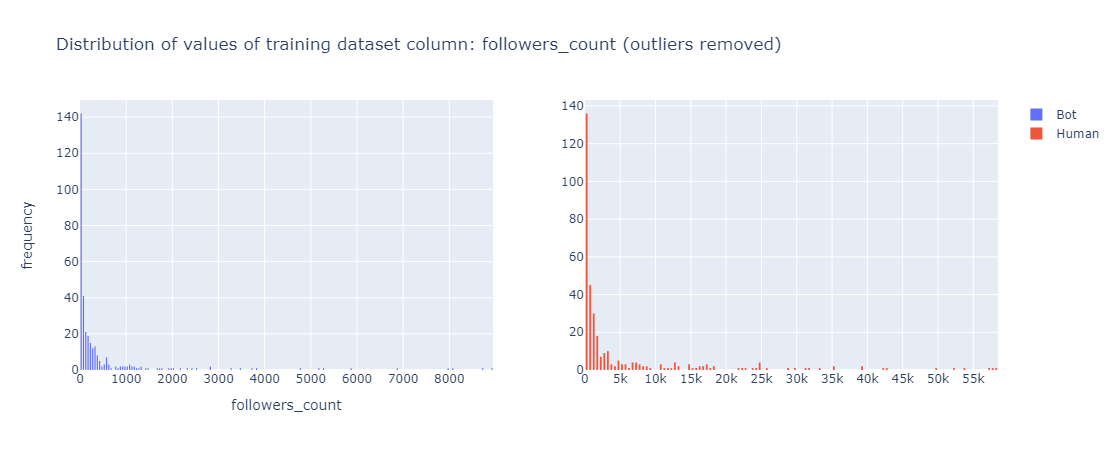

In [598]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_followers_count.loc[df_reduced_outliers_followers_count['label']==1,'followers_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_followers_count.loc[df_reduced_outliers_followers_count['label']==0,'followers_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: followers_count (outliers removed)',
    xaxis_title_text='followers_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1000),
    xaxis2=dict(showgrid=True, dtick=5000),
    yaxis=dict(showgrid=True))

fig.show()

#### following_count

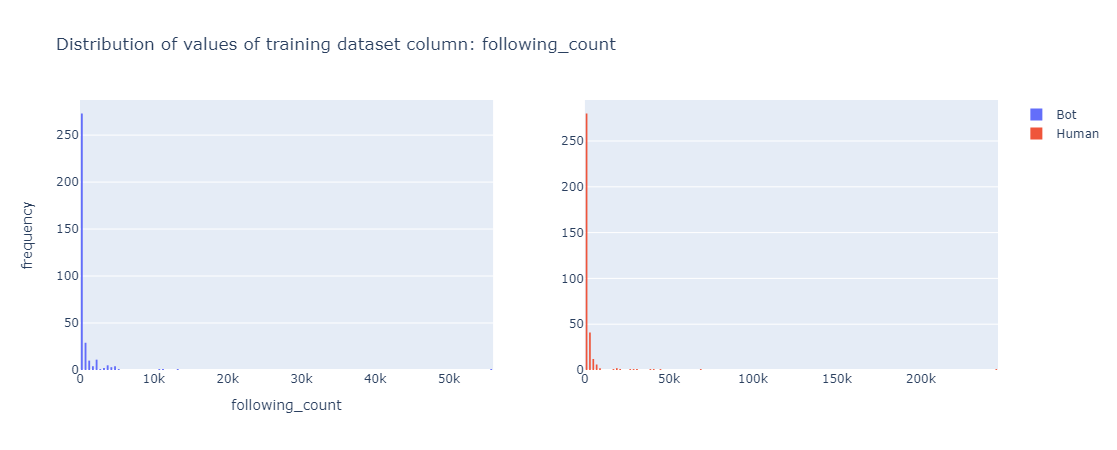

In [599]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'following_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'following_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: following_count',
    xaxis_title_text='following_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    # xaxis=dict(showgrid=True, dtick=10000),
    # xaxis2=dict(showgrid=True, dtick=10000),
    yaxis=dict(showgrid=True))

fig.show()

#### following_count - outliers

In [600]:
df_reduced_outliers_following_count = df_99_percentile(df=train_data, column_name='following_count')

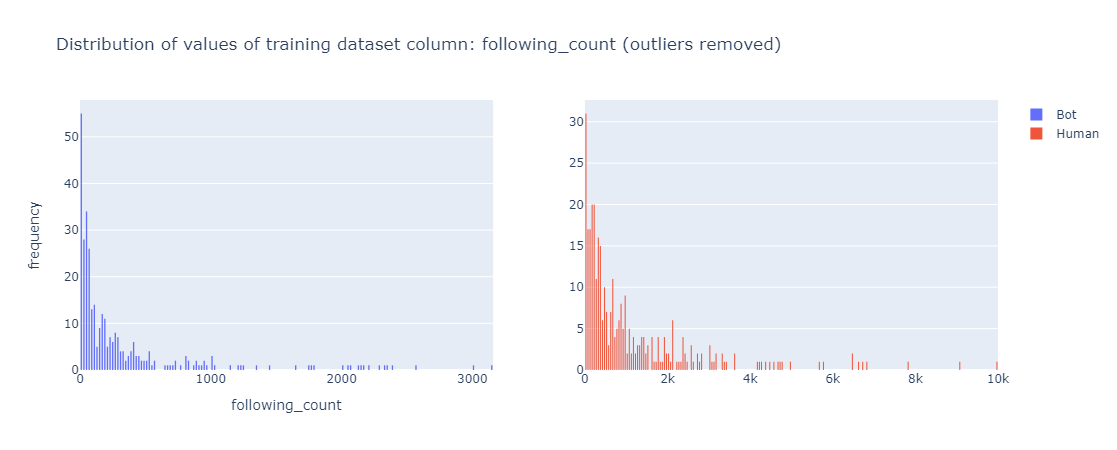

In [601]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_following_count.loc[df_reduced_outliers_following_count['label']==1,'following_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_following_count.loc[df_reduced_outliers_following_count['label']==0,'following_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: following_count (outliers removed)',
    xaxis_title_text='following_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    # xaxis=dict(showgrid=True, dtick=10000),
    # xaxis2=dict(showgrid=True, dtick=10000),
    yaxis=dict(showgrid=True))

fig.show()

#### tweet_count

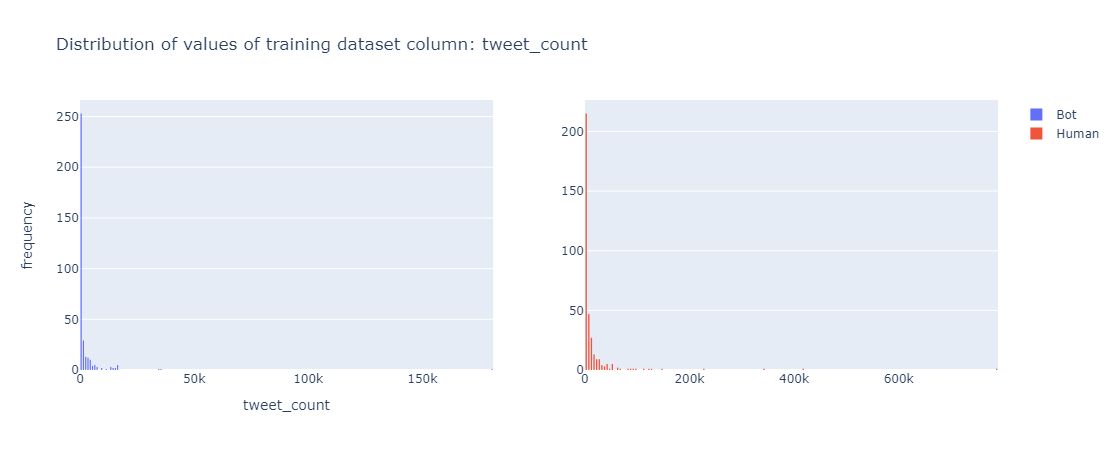

In [602]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'tweet_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'tweet_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: tweet_count',
    xaxis_title_text='tweet_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    # xaxis=dict(showgrid=True, dtick=50000),
    # xaxis2=dict(showgrid=True, dtick=50000),
    yaxis=dict(showgrid=True))

fig.show()

#### tweet_count - outliers

In [603]:
df_reduced_outliers_tweet_count = df_99_percentile(df=train_data, column_name='tweet_count')

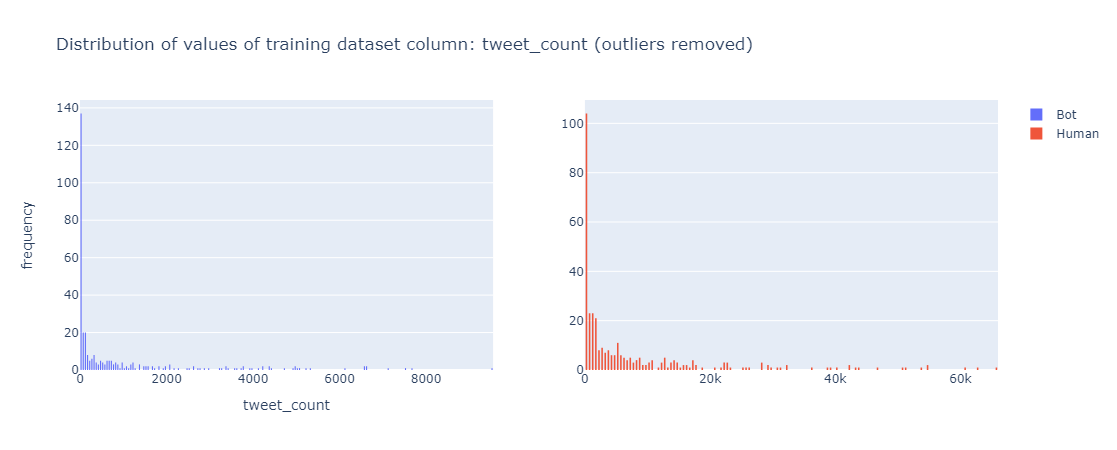

In [604]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_tweet_count.loc[df_reduced_outliers_tweet_count['label']==1,'tweet_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_tweet_count.loc[df_reduced_outliers_tweet_count['label']==0,'tweet_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: tweet_count (outliers removed)',
    xaxis_title_text='tweet_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    # xaxis=dict(showgrid=True, dtick=1000),
    # xaxis2=dict(showgrid=True, dtick=5000),
    yaxis=dict(showgrid=True))

fig.show()

### listed_count

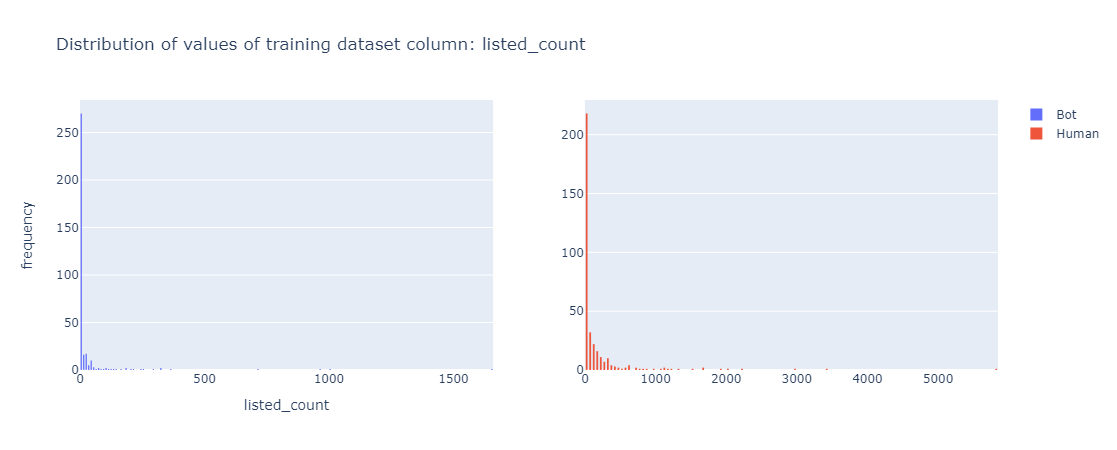

In [605]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'listed_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'listed_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: listed_count',
    xaxis_title_text='listed_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    # xaxis=dict(showgrid=True, dtick=1000),
    # xaxis2=dict(showgrid=True, dtick=1000),
    yaxis=dict(showgrid=True))

fig.show()

#### listed_count - outliers

In [606]:
df_reduced_outliers_listed_count = df_99_percentile(df=train_data, column_name='listed_count')

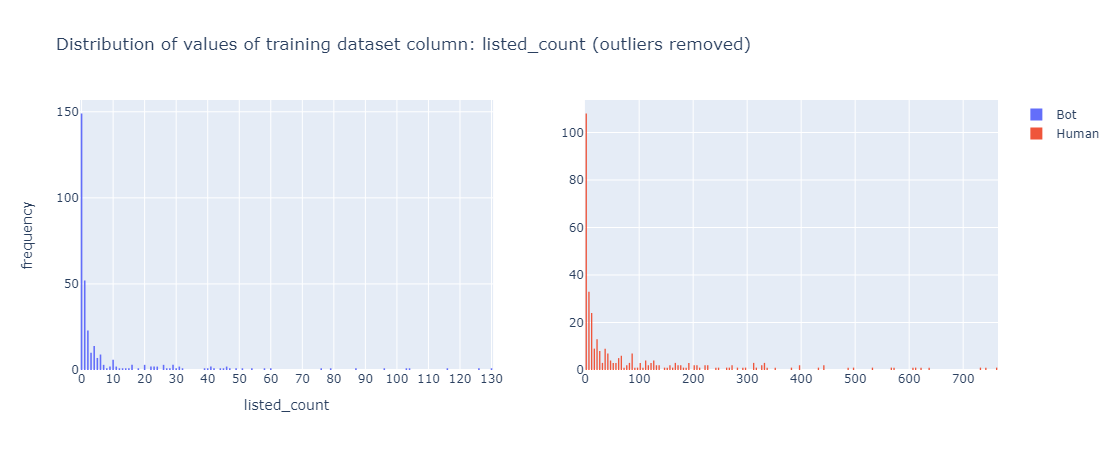

In [607]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_listed_count.loc[df_reduced_outliers_listed_count['label']==1,'listed_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_listed_count.loc[df_reduced_outliers_listed_count['label']==0,'listed_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: listed_count (outliers removed)',
    xaxis_title_text='listed_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=10),
    xaxis2=dict(showgrid=True, dtick=100),
    yaxis=dict(showgrid=True))

fig.show()

### ['descr_no_hashtags', 'descr_no_cashtags', 'descr_no_mentions', 'descr_no_urls', 'descr_len', 'url_no_urls']

### descr_no_hashtags

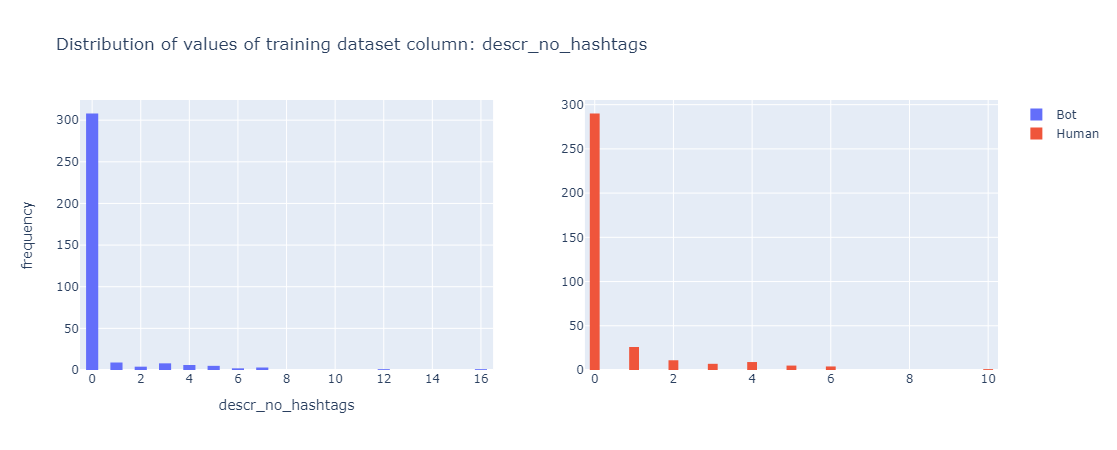

In [608]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'descr_no_hashtags'],
    # histnorm='density',
    nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'descr_no_hashtags'],
    # histnorm='density',
    nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_hashtags',
    xaxis_title_text='descr_no_hashtags', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=2),
    xaxis2=dict(showgrid=True, dtick=2),
    yaxis=dict(showgrid=True))

fig.show()

#### descr_no_hashtags - outliers

In [609]:
df_reduced_outliers_descr_no_hashtags = df_99_percentile(df=train_data, column_name='descr_no_hashtags')

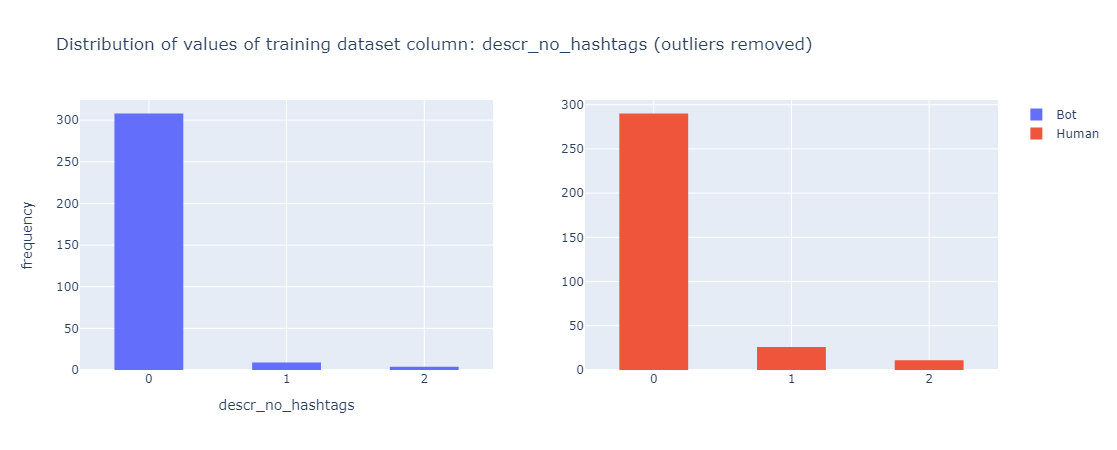

In [610]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_hashtags.loc[df_reduced_outliers_descr_no_hashtags['label']==1,'descr_no_hashtags'],
    # histnorm='density',
    # nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_hashtags.loc[df_reduced_outliers_descr_no_hashtags['label']==0,'descr_no_hashtags'],
    # histnorm='density',
    # nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_hashtags (outliers removed)',
    xaxis_title_text='descr_no_hashtags', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

### descr_no_cashtags


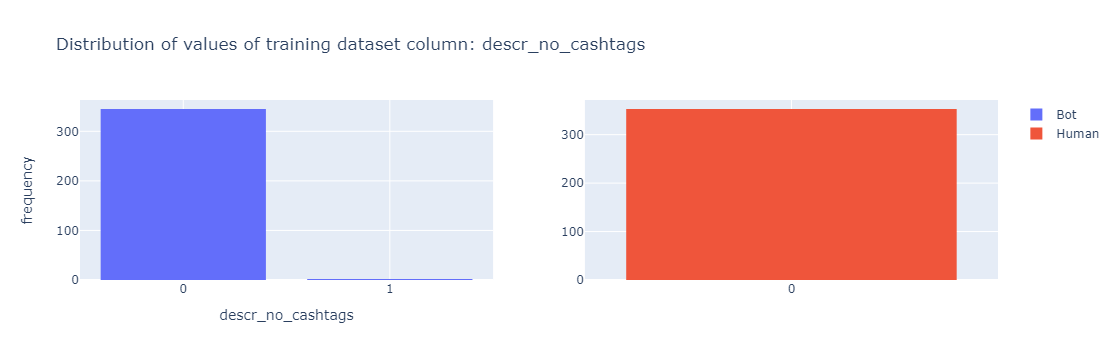

In [611]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'descr_no_cashtags'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'descr_no_cashtags'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_cashtags',
    xaxis_title_text='descr_no_cashtags', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

#### descr_no_cashtags - outliers

In [612]:
df_reduced_outliers_descr_no_cashtags = df_99_percentile(df=train_data, column_name='descr_no_cashtags')

/opt/conda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2129: RuntimeWarning:

invalid value encountered in multiply



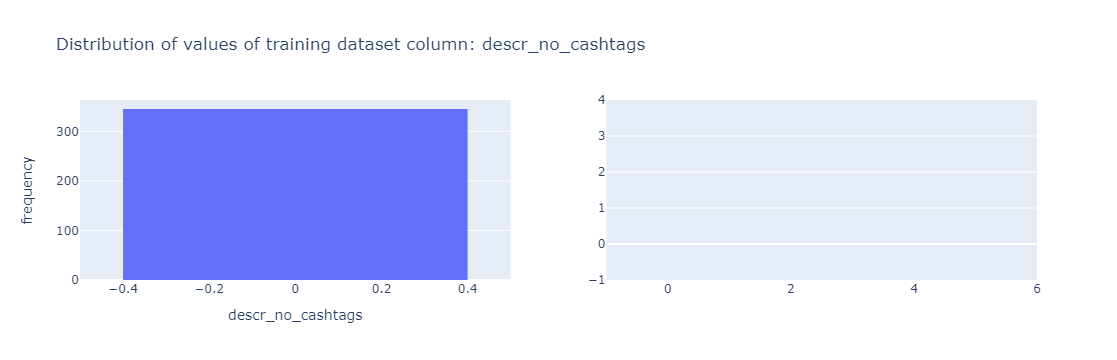

In [613]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_cashtags.loc[df_reduced_outliers_descr_no_cashtags['label']==1,'descr_no_cashtags'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_cashtags.loc[df_reduced_outliers_descr_no_cashtags['label']==0,'descr_no_cashtags'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_cashtags',
    xaxis_title_text='descr_no_cashtags', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    # xaxis=dict(showgrid=True, dtick=1),
    # xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

Better to drop this column (DONE, droped later)

### descr_no_mentions

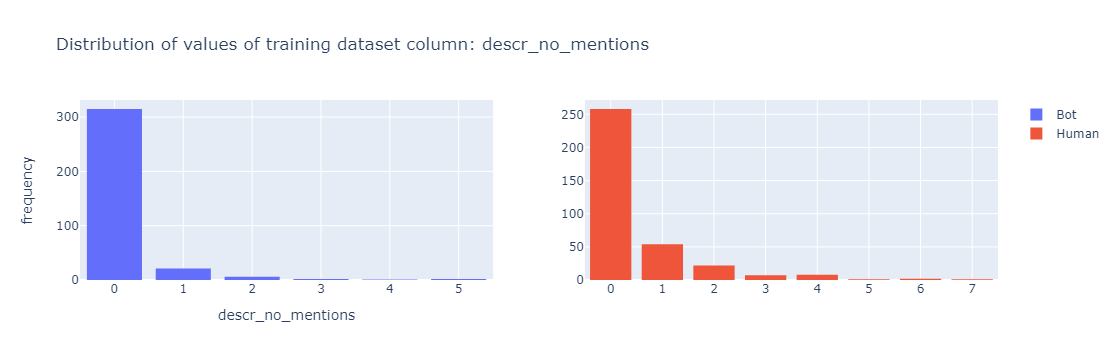

In [614]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'descr_no_mentions'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'descr_no_mentions'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_mentions',
    xaxis_title_text='descr_no_mentions', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

#### descr_no_mentions - outliers

In [615]:
df_reduced_outliers_descr_no_mentions = df_99_percentile(df=train_data, column_name='descr_no_mentions')

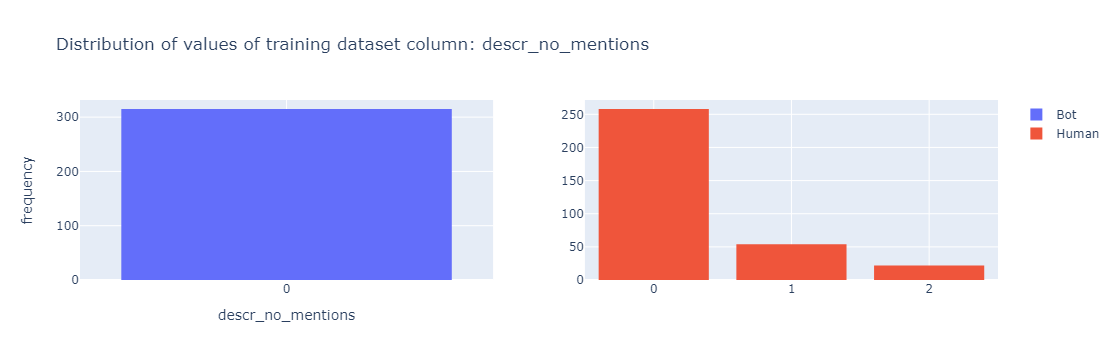

In [616]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_mentions.loc[df_reduced_outliers_descr_no_mentions['label']==1,'descr_no_mentions'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_mentions.loc[df_reduced_outliers_descr_no_mentions['label']==0,'descr_no_mentions'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_mentions',
    xaxis_title_text='descr_no_mentions', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

### descr_no_urls

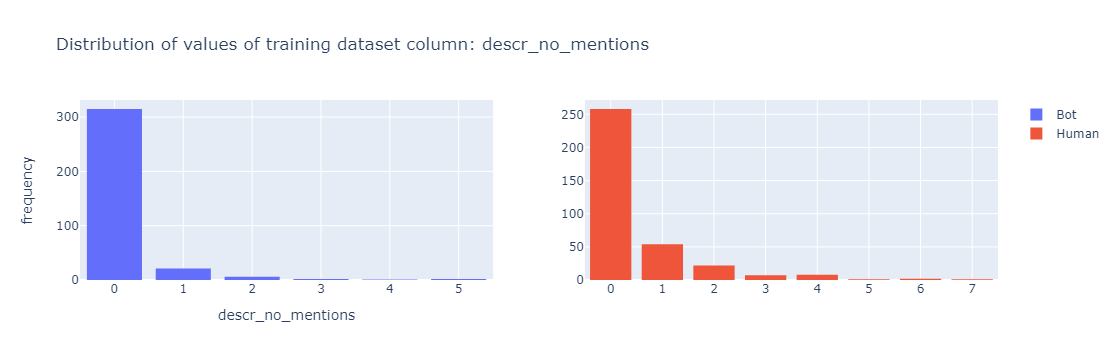

In [617]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'descr_no_mentions'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'descr_no_mentions'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_mentions',
    xaxis_title_text='descr_no_mentions', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

#### descr_no_urls - outliers

In [618]:
df_reduced_outliers_descr_no_urls = df_99_percentile(df=train_data, column_name='descr_no_urls')

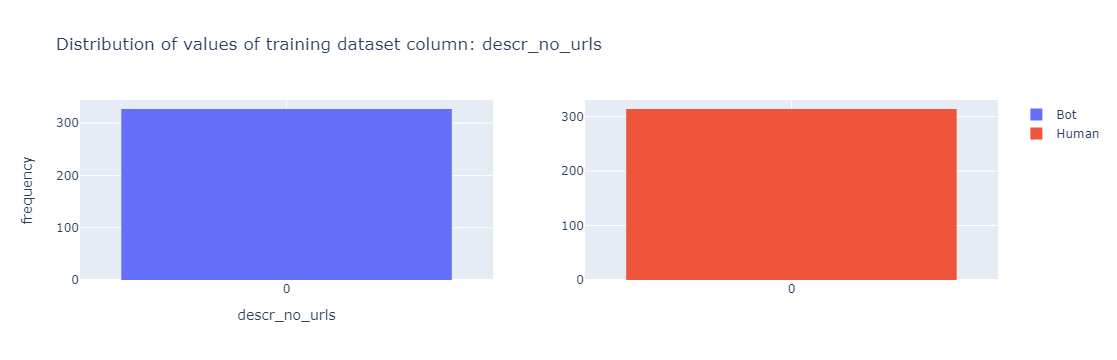

In [619]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_urls.loc[df_reduced_outliers_descr_no_urls['label']==1,'descr_no_urls'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_urls.loc[df_reduced_outliers_descr_no_urls['label']==0,'descr_no_urls'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_urls',
    xaxis_title_text='descr_no_urls', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

Better to drop this column (DONE, droped later)

### url_no_urls

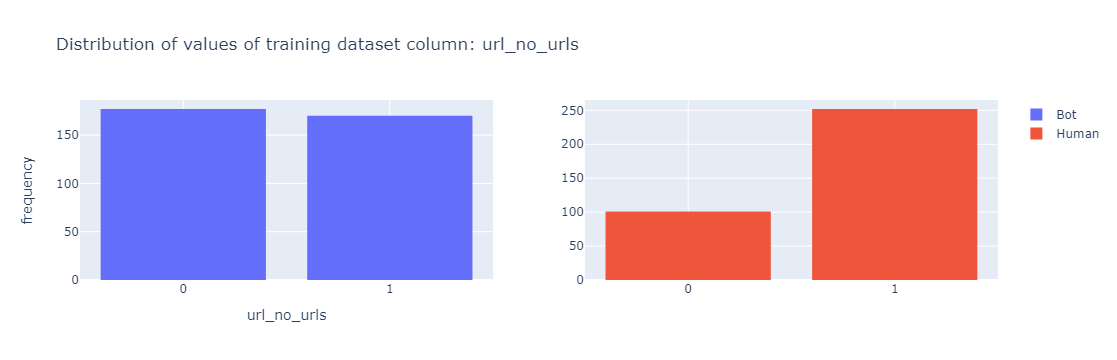

In [620]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'url_no_urls'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'url_no_urls'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: url_no_urls',
    xaxis_title_text='url_no_urls', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

#### url_no_urls - outliers

In [621]:
df_reduced_outliers_url_no_urls = df_99_percentile(df=train_data, column_name='url_no_urls')

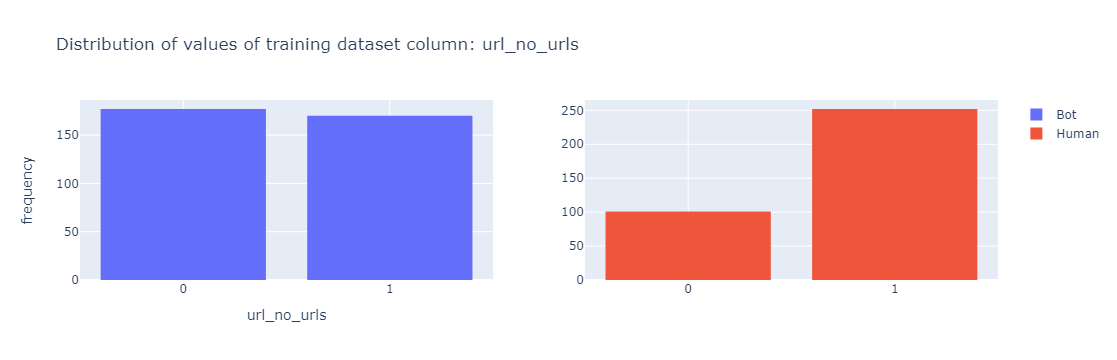

In [622]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_url_no_urls.loc[df_reduced_outliers_url_no_urls['label']==1,'url_no_urls'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_url_no_urls.loc[df_reduced_outliers_url_no_urls['label']==0,'url_no_urls'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: url_no_urls',
    xaxis_title_text='url_no_urls', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

### descr_len

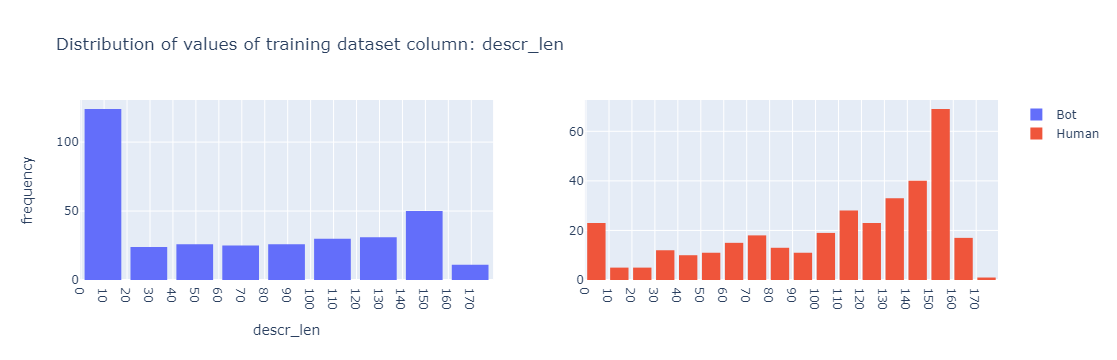

In [623]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'descr_len'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'descr_len'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_len',
    xaxis_title_text='descr_len', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=10),
    xaxis2=dict(showgrid=True, dtick=10),
    yaxis=dict(showgrid=True))

fig.show()

#### descr_len - outliers

In [624]:
q_hi_bots1 = train_data.loc[train_data['label']==1]['descr_len'].quantile(0.99, interpolation='nearest')
q_hi_humans1 = train_data.loc[train_data['label']==0]['descr_len'].quantile(0.99, interpolation='nearest')

df_reduced_outliers_descr_len =  train_data[((train_data['label']==1) & (train_data['descr_len'] < q_hi_bots1)) | ((train_data['label']==0) & (train_data['descr_len'] < q_hi_humans1))]

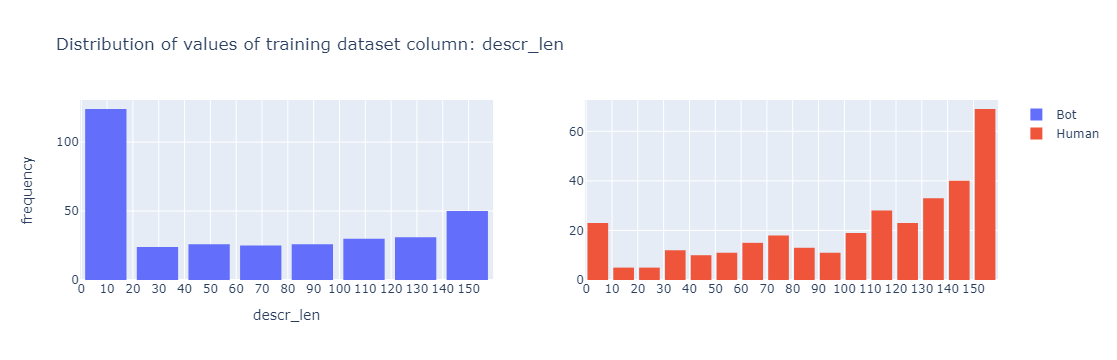

In [625]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_len.loc[df_reduced_outliers_descr_len['label']==1,'descr_len'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_len.loc[df_reduced_outliers_descr_len['label']==0,'descr_len'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_len',
    xaxis_title_text='descr_len', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=10),
    xaxis2=dict(showgrid=True, dtick=10),
    yaxis=dict(showgrid=True))

fig.show()

### account_age

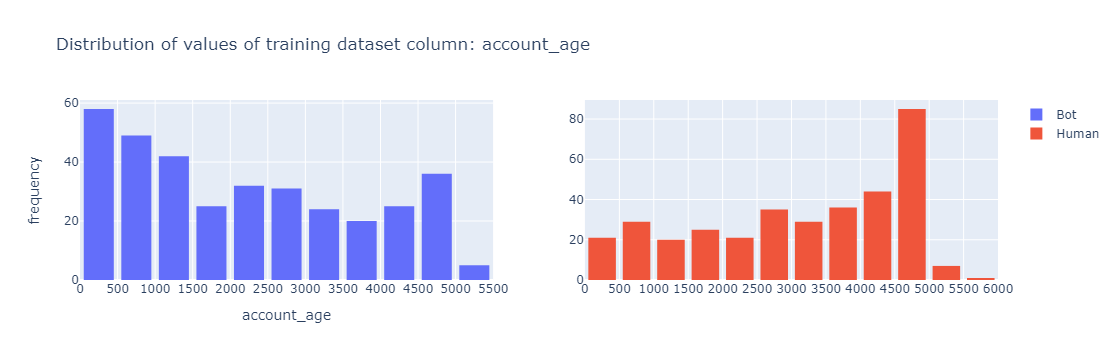

In [626]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'account_age'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'account_age'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: account_age',
    xaxis_title_text='account_age', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=500),
    xaxis2=dict(showgrid=True, dtick=500),
    yaxis=dict(showgrid=True))

fig.show()

#### account_age - outliers

In [627]:
q_hi_bots2 = train_data.loc[train_data['label']==1]['account_age'].quantile(0.99, interpolation='nearest')
q_hi_humans2 = train_data.loc[train_data['label']==0]['account_age'].quantile(0.99, interpolation='nearest')

df_reduced_outliers_account_age =  train_data[((train_data['label']==1) & (train_data['account_age'] < q_hi_bots2)) | ((train_data['label']==0) & (train_data['account_age'] < q_hi_humans2))]

### Create merged dataframe from reduced by columns outliers dataframes

In [628]:
train_data_wo_outliers = df_reduced_outliers_followers_count.merge(df_reduced_outliers_following_count, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

rest_of_df = [df_reduced_outliers_tweet_count, 
              df_reduced_outliers_listed_count, 
              df_reduced_outliers_descr_no_hashtags, 
              df_reduced_outliers_descr_no_cashtags,
              df_reduced_outliers_descr_no_mentions,
              df_reduced_outliers_descr_no_urls,
              df_reduced_outliers_url_no_urls,
              df_reduced_outliers_descr_len,
              df_reduced_outliers_account_age]

for df in rest_of_df:
    if (len(df.loc[df['label']==1]) > 0 and len(df.loc[df['label']==0]) > 0):
        train_data_wo_outliers = train_data_wo_outliers.merge(df, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

In [629]:
len(train_data)

700

In [630]:
len(train_data_wo_outliers)

481

In [631]:
train_data_wo_outliers

id  label  verified  protected  has_location  has_pinned_tweet  \
0    1.376538e+18    0.0       0.0        0.0           1.0               0.0   
1    2.911150e+09    1.0       0.0        0.0           1.0               0.0   
2    1.311138e+18    1.0       0.0        0.0           0.0               0.0   
3    1.516855e+09    0.0       0.0        0.0           1.0               0.0   
4    2.324969e+08    0.0       0.0        0.0           1.0               0.0   
..            ...    ...       ...        ...           ...               ...   
476  2.656623e+08    0.0       0.0        0.0           1.0               0.0   
477  1.659154e+08    0.0       0.0        0.0           1.0               1.0   
478  4.953350e+08    0.0       0.0        0.0           1.0               0.0   
479  8.724894e+07    0.0       0.0        0.0           1.0               0.0   
480  1.931782e+09    1.0       0.0        0.0           0.0               0.0   

     followers_count  following_count  tweet_count  listed_count  \
0               77.0            194.0        154.0           0.0   
1              338.0            335.0        811.0          14.0   
2                2.0             51.0          2.0           0.0   
3              671.0           1215.0        296.0          13.0   
4               41.0            109.0         14.0           1.0   
..               ...              ...          ...           ...   
476            440.0            502.0      17028.0          50.0   
477            796.0            335.0       2663.0          16.0   
478           1847.0           1166.0       8953.0         122.0   
479           1818.0            921.0       8957.0          62.0   
480             12.0            117.0        670.0           0.0   

     has_description  descr_no_hashtags  descr_no_cashtags  descr_no_mentions  \
0                1.0                0.0                0.0                0.0   
1                1.0                1.0                0.0                0.0   
2                0.0                0.0                0.0                0.0   
3                1.0                0.0                0.0                1.0   
4                1.0                0.0                0.0                0.0   
..               ...                ...                ...                ...   
476              1.0                1.0                0.0                0.0   
477              1.0                0.0                0.0                1.0   
478              1.0                0.0                0.0                0.0   
479              1.0                0.0                0.0                0.0   
480              1.0                0.0                0.0                0.0   

     descr_no_urls  url_no_urls  descr_len  account_age  
0              0.0          0.0       50.0        352.0  
1              0.0          1.0      136.0       2667.0  
2              0.0          0.0        0.0        532.0  
3              0.0          1.0       81.0       3197.0  
4              0.0          0.0       84.0       4093.0  
..             ...          ...        ...          ...  
476            0.0          1.0       81.0       4021.0  
477            0.0          0.0      139.0       4265.0  
478            0.0          1.0      159.0       3680.0  
479            0.0          1.0       42.0       4516.0  
480            0.0          1.0      118.0       3086.0  

[481 rows x 18 columns]

#### Drop 'id' column

In [632]:
train_data = train_data.drop(['id'], axis=1)
val_data = val_data.drop(['id'], axis=1)
test_data = test_data.drop(['id'], axis=1)

train_data_wo_outliers = train_data_wo_outliers.drop(['id'], axis=1)
val_data_wo_outliers = val_data_wo_outliers.drop(['id'], axis=1)
test_data_wo_outliers = test_data_wo_outliers.drop(['id'], axis=1)

### Filter to have the same number of records for each class - part II

In [633]:
train_data = filter_df_for_balanced_classes(train_data, bot_label_value=1, human_label_value=0)
val_data = filter_df_for_balanced_classes(val_data, bot_label_value=1, human_label_value=0)
test_data = filter_df_for_balanced_classes(test_data, bot_label_value=1, human_label_value=0)

Number of bots:  347
Number of human users:  347
Number of bots:  67
Number of human users:  67
Number of bots:  70
Number of human users:  70


In [634]:
train_data_wo_outliers = filter_df_for_balanced_classes(train_data_wo_outliers, bot_label_value=1, human_label_value=0)
val_data_wo_outliers = filter_df_for_balanced_classes(val_data_wo_outliers, bot_label_value=1, human_label_value=0)
test_data_wo_outliers = filter_df_for_balanced_classes(test_data_wo_outliers, bot_label_value=1, human_label_value=0)

Number of bots:  237
Number of human users:  237
Number of bots:  67
Number of human users:  67
Number of bots:  70
Number of human users:  70


## Correlation

In [635]:
sns.set(font_scale=2)

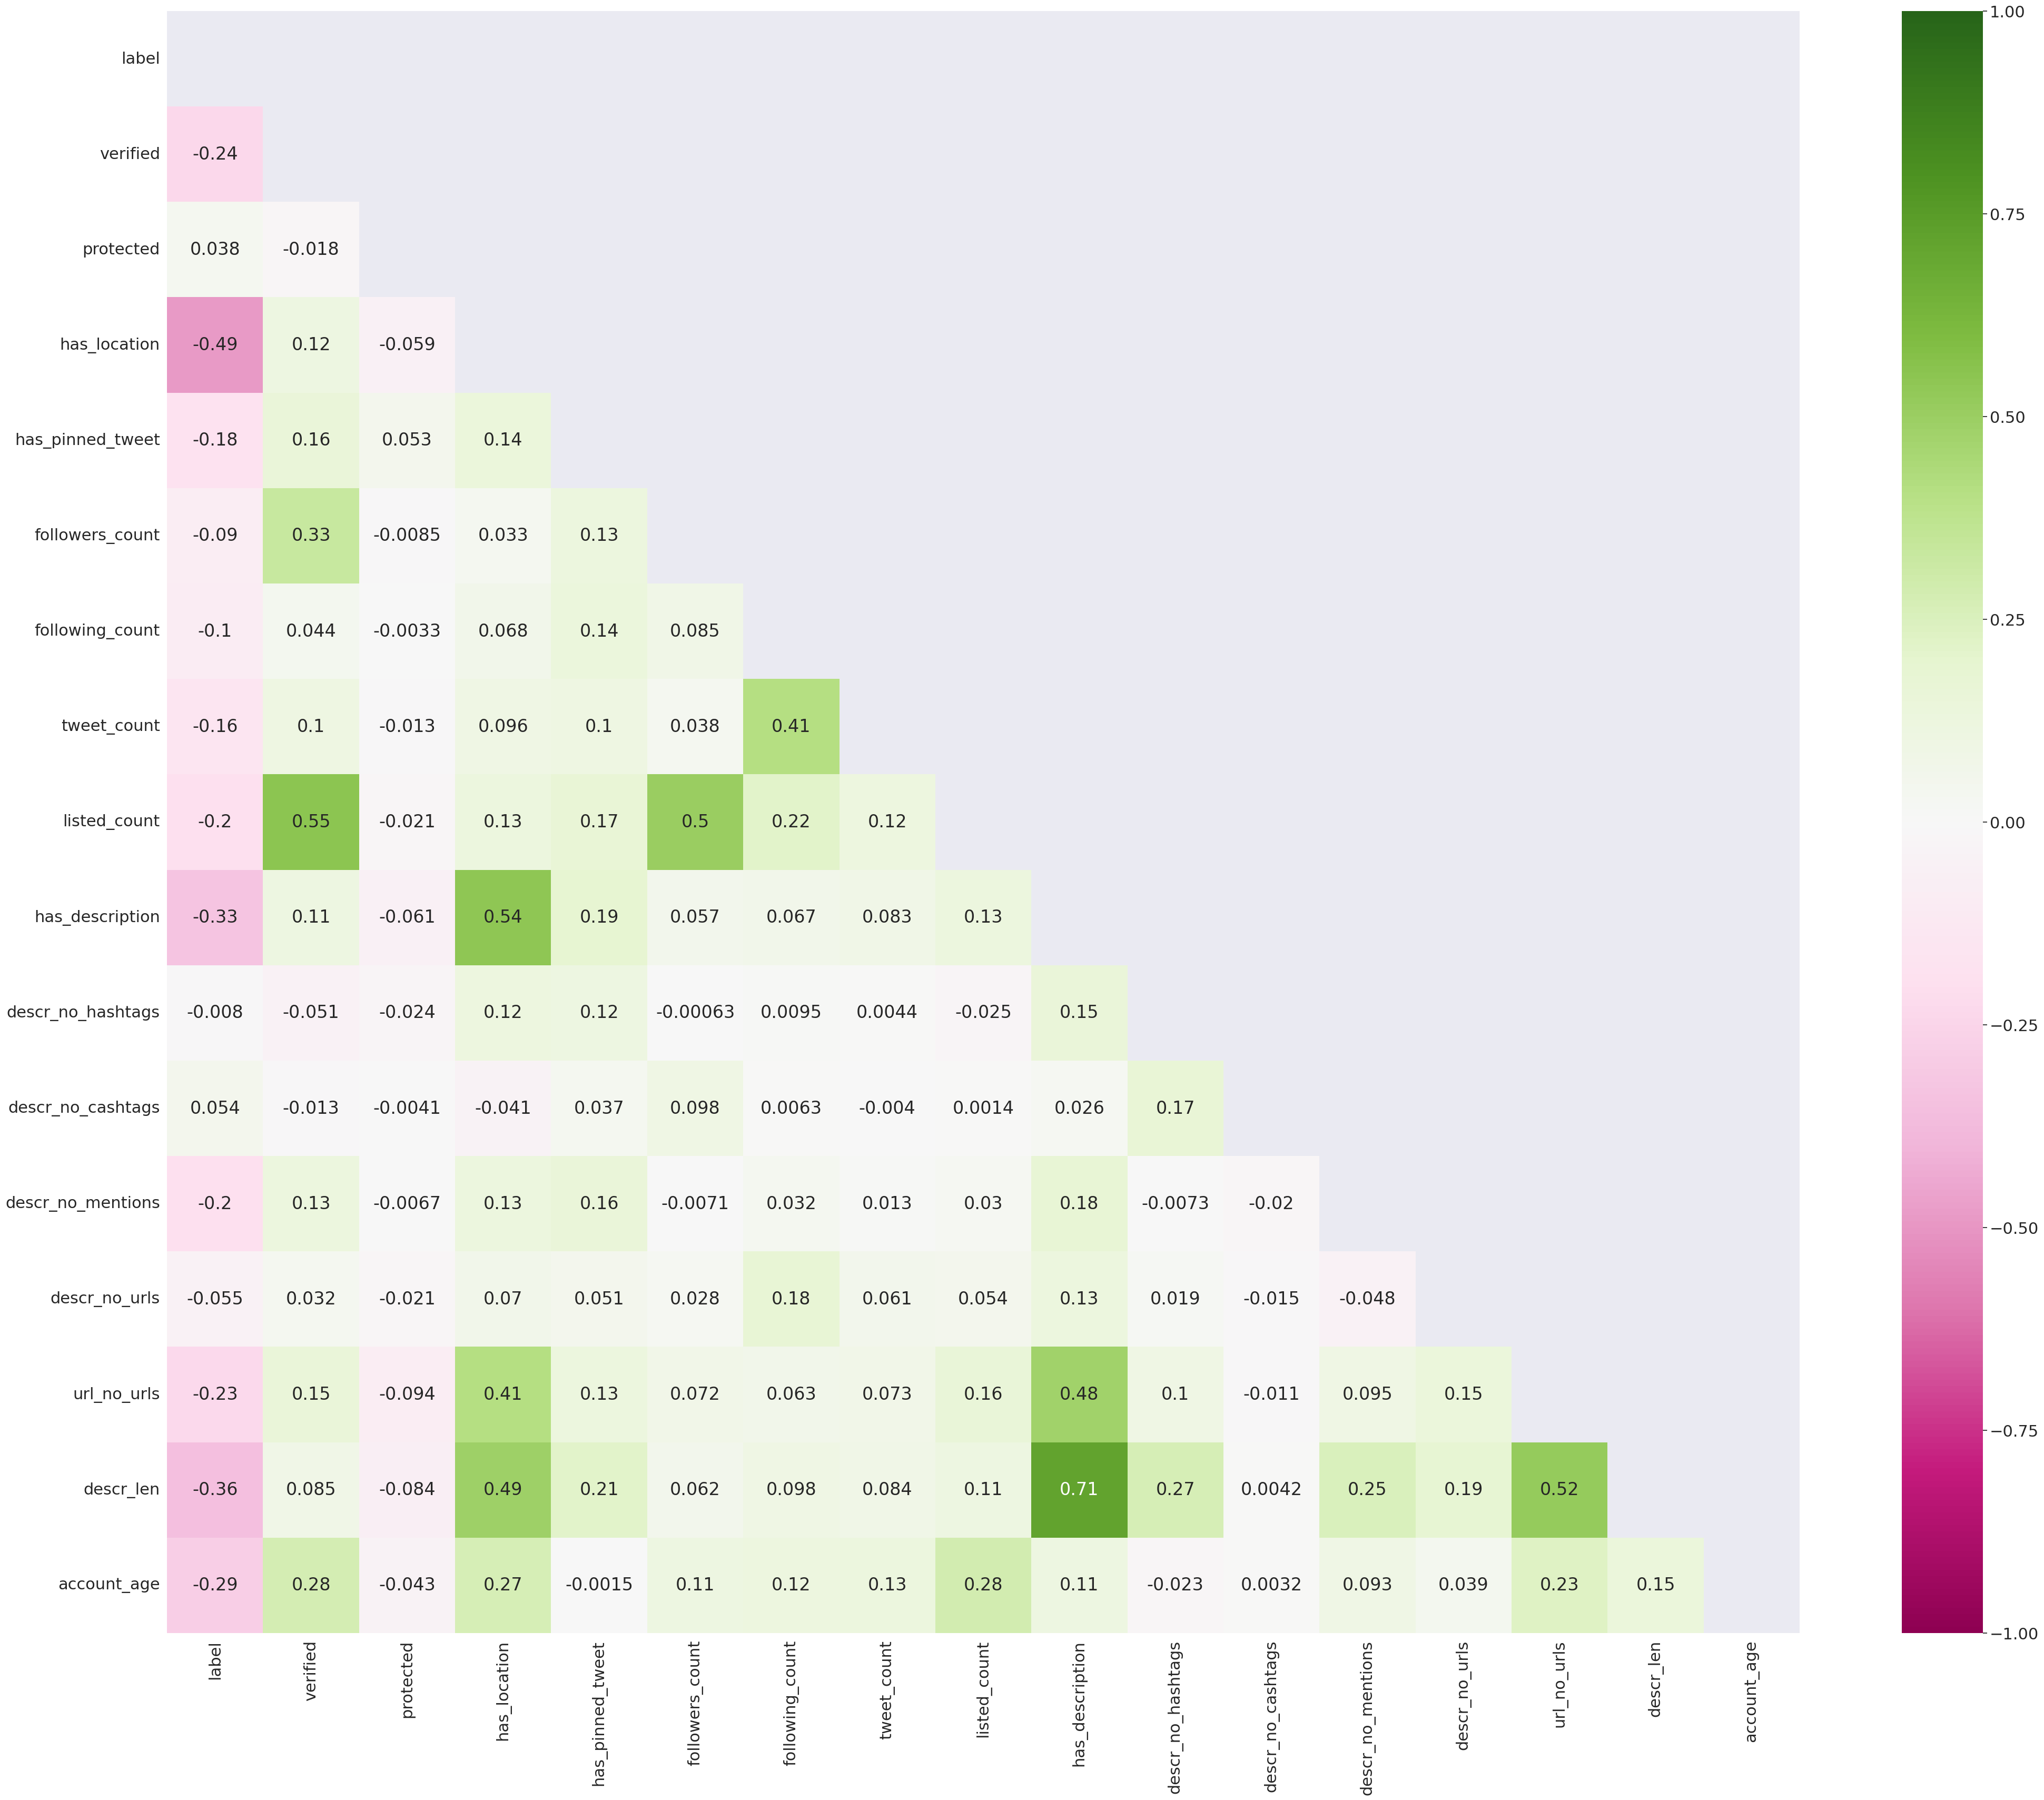

In [636]:
corr_threshold = 0.52
corr = train_data.corr()
lower_tri = corr.where(np.tril(np.ones(corr.shape),k=-1).astype(bool)) #creating lower triangular correlation matrix
f = plt.figure(figsize=(50, 40))
sns.heatmap(lower_tri, cmap="PiYG", annot=True, vmin=-1, vmax=1, ax=plt.gca()) #, annot_kws={"fontsize": 16})
high_corr = []
for column in train_data:
   for col in train_data:
     if abs(lower_tri[column][col]) > corr_threshold:
         high_corr.append((column, col, lower_tri[column][col]))
high_corr = sorted(high_corr, key=lambda x: x[2], reverse=True)

In [637]:
sns.set(font_scale=1)

In [638]:
print("Number of columns containing high correlation:", len(set([x[0] for x in high_corr])))
high_corr

Number of columns containing high correlation: 4


[('has_description', 'descr_len', 0.7118253676511368),
 ('verified', 'listed_count', 0.5529585966964448),
 ('has_location', 'has_description', 0.5418682683934204),
 ('url_no_urls', 'descr_len', 0.5201083640983655)]

In [639]:
train_data

label  verified  protected  has_location  has_pinned_tweet  \
357    0.0       0.0        0.0           1.0               0.0   
114    1.0       0.0        0.0           1.0               0.0   
268    1.0       0.0        0.0           0.0               0.0   
665    0.0       0.0        0.0           1.0               0.0   
856    1.0       0.0        0.0           1.0               0.0   
..     ...       ...        ...           ...               ...   
940    1.0       0.0        0.0           1.0               1.0   
886    1.0       0.0        0.0           1.0               0.0   
474    1.0       0.0        0.0           1.0               0.0   
318    1.0       0.0        0.0           0.0               0.0   
132    1.0       0.0        0.0           1.0               0.0   

     followers_count  following_count  tweet_count  listed_count  \
357             77.0            194.0        154.0           0.0   
114            338.0            335.0        811.0          14.0   
268              2.0             51.0          2.0           0.0   
665            671.0           1215.0        296.0          13.0   
856            285.0            210.0         76.0          31.0   
..               ...              ...          ...           ...   
940            372.0              1.0      13283.0           2.0   
886             55.0            218.0        350.0           0.0   
474           8708.0          10660.0        869.0         168.0   
318             12.0            117.0        670.0           0.0   
132            363.0            289.0       1282.0          31.0   

     has_description  descr_no_hashtags  descr_no_cashtags  descr_no_mentions  \
357              1.0                0.0                0.0                0.0   
114              1.0                1.0                0.0                0.0   
268              0.0                0.0                0.0                0.0   
665              1.0                0.0                0.0                1.0   
856              1.0                0.0                0.0                1.0   
..               ...                ...                ...                ...   
940              1.0                0.0                0.0                0.0   
886              1.0                3.0                0.0                0.0   
474              1.0                0.0                0.0                0.0   
318              1.0                0.0                0.0                0.0   
132              1.0                0.0                0.0                1.0   

     descr_no_urls  url_no_urls  descr_len  account_age  
357            0.0          0.0       50.0        352.0  
114            0.0          1.0      136.0       2667.0  
268            0.0          0.0        0.0        532.0  
665            0.0          1.0       81.0       3197.0  
856            0.0          1.0      117.0       4767.0  
..             ...          ...        ...          ...  
940            0.0          0.0      159.0        999.0  
886            0.0          1.0       94.0         46.0  
474            0.0          0.0      157.0       4716.0  
318            0.0          1.0      118.0       3086.0  
132            0.0          1.0      107.0       4697.0  

[694 rows x 17 columns]

In [640]:
train_data = train_data.drop(['listed_count'], axis=1)
val_data = val_data.drop(['listed_count'], axis=1)
test_data = test_data.drop(['listed_count'], axis=1)

train_data = train_data.drop(['has_description'], axis=1)
val_data = val_data.drop(['has_description'], axis=1)
test_data = test_data.drop(['has_description'], axis=1)

train_data = train_data.drop(['url_no_urls'], axis=1)
val_data = val_data.drop(['url_no_urls'], axis=1)
test_data = test_data.drop(['url_no_urls'], axis=1)

### Correlation of data reduced by outliers

#### First drop columns in filter (without outliers) dataframe where now have same value in whole column

In [641]:
same_data_columns = list(train_data_wo_outliers.columns[train_data_wo_outliers.apply(lambda x: x.nunique()) == 1])
same_data_columns

['descr_no_cashtags', 'descr_no_urls']

In [642]:
train_data_wo_outliers = train_data_wo_outliers.drop(same_data_columns, axis=1)

val_data_wo_outliers = val_data_wo_outliers.drop(same_data_columns, axis=1)
test_data_wo_outliers = test_data_wo_outliers.drop(same_data_columns, axis=1)

#### Correlation

In [643]:
sns.set(font_scale=2)

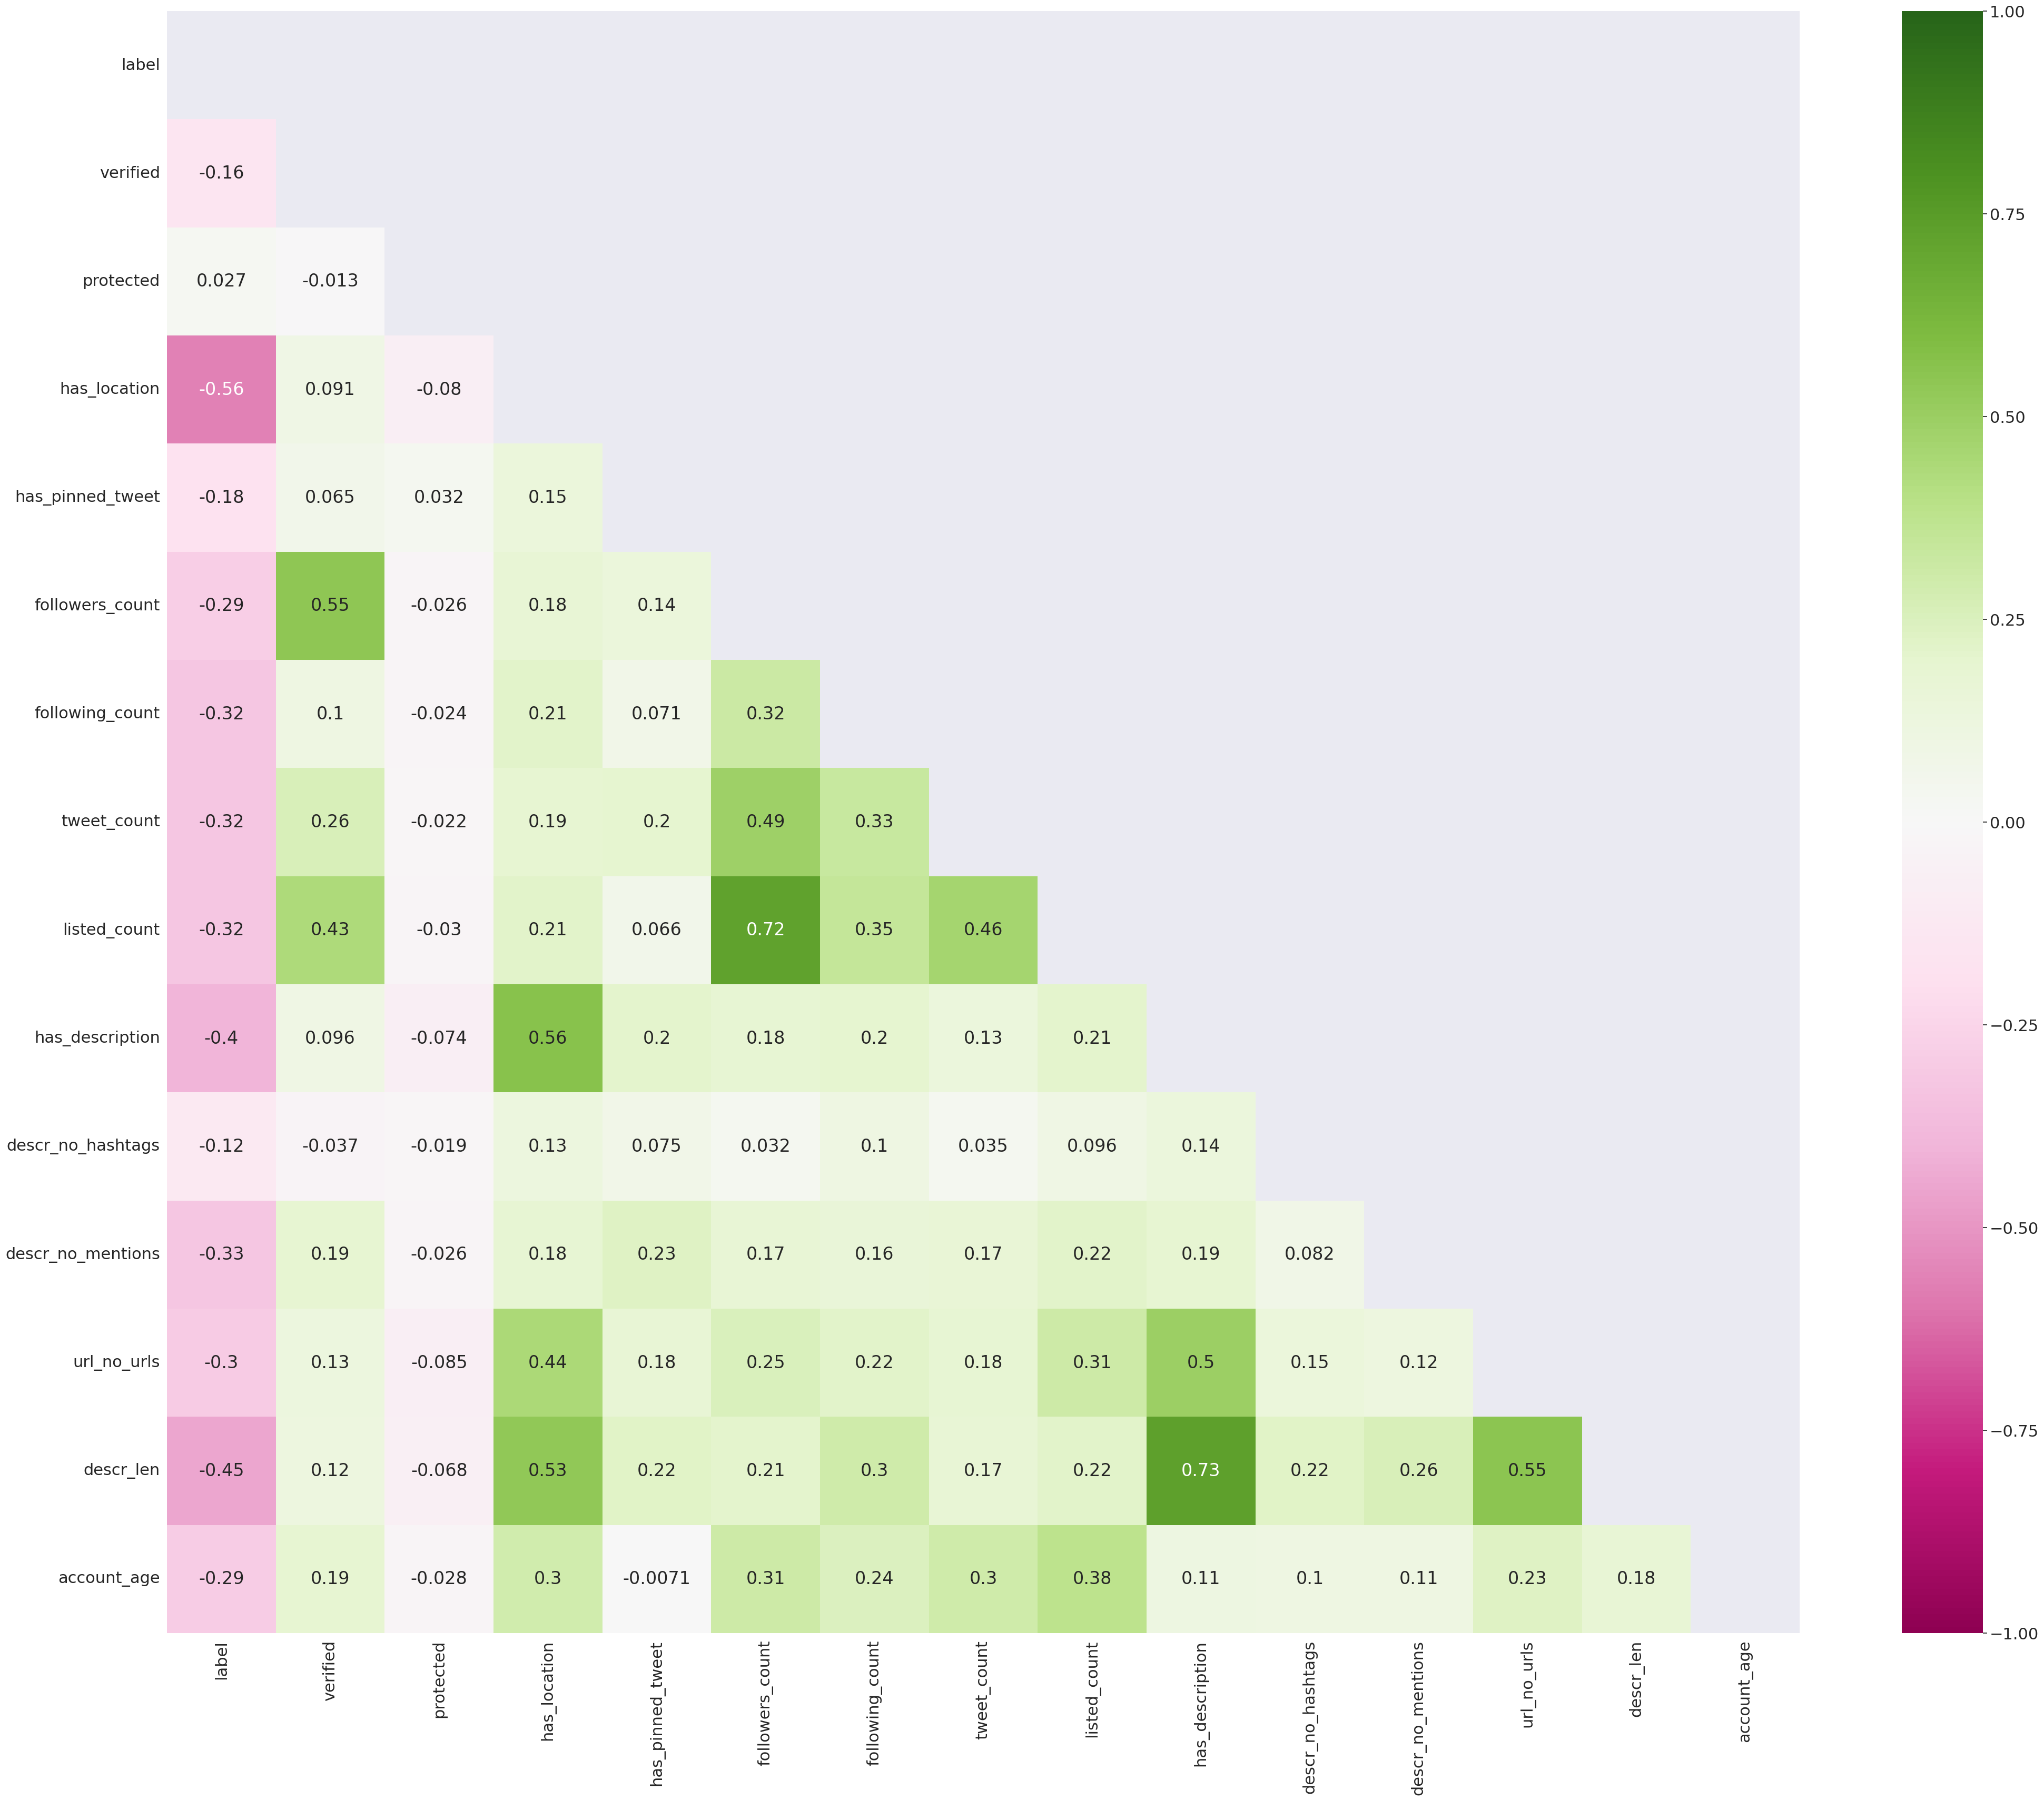

In [644]:
corr_threshold2 = 0.52
corr2 = train_data_wo_outliers.corr()
lower_tri2 = corr2.where(np.tril(np.ones(corr2.shape),k=-1).astype(bool)) #creating lower triangular correlation matrix
f = plt.figure(figsize=(50, 40))
sns.heatmap(lower_tri2, cmap="PiYG", annot=True, vmin=-1, vmax=1, ax=plt.gca()) #, annot_kws={"fontsize": 16})
high_corr2 = []
for column in train_data_wo_outliers:
   for col in train_data_wo_outliers:
     if abs(lower_tri2[column][col]) > corr_threshold2:
         high_corr2.append((column, col, lower_tri2[column][col]))
high_corr2 = sorted(high_corr2, key=lambda x: x[2], reverse=True)

#### Drop column with higher correlation

In [645]:
f = plt.figure(figsize=(50, 40))
sns.set(font_scale=1)

<Figure size 5000x4000 with 0 Axes>

In [646]:
high_corr2

[('has_description', 'descr_len', 0.731450324565637),
 ('followers_count', 'listed_count', 0.7194961989337069),
 ('has_location', 'has_description', 0.5635550623954355),
 ('url_no_urls', 'descr_len', 0.5535278754512385),
 ('verified', 'followers_count', 0.5451765743580237),
 ('has_location', 'descr_len', 0.5331788666794065),
 ('label', 'has_location', -0.5627314338711376)]

In [647]:
train_data_wo_outliers = train_data_wo_outliers.drop(['listed_count', 'has_description', 'url_no_urls'], axis=1)
val_data_wo_outliers = val_data_wo_outliers.drop(['listed_count', 'has_description', 'url_no_urls'], axis=1)
test_data_wo_outliers = test_data_wo_outliers.drop(['listed_count', 'has_description', 'url_no_urls'], axis=1)

#### Split data for input and output

In [648]:
train_X = train_data.drop(['label'], axis=1)
train_Y = pd.concat([train_data['label']], axis=1)
val_X = val_data.drop(['label'], axis=1)
val_Y = pd.concat([val_data['label']], axis=1)
test_X = test_data.drop(['label'], axis=1)
test_Y = pd.concat([test_data['label']], axis=1)


train_data_wo_outliers_X = train_data_wo_outliers.drop(['label'], axis=1)
train_data_wo_outliers_Y = pd.concat([train_data_wo_outliers['label']], axis=1)
val_data_wo_outliers_X = val_data_wo_outliers.drop(['label'], axis=1)
val_data_wo_outliers_Y = pd.concat([val_data_wo_outliers['label']], axis=1)
test_data_wo_outliers_X = test_data_wo_outliers.drop(['label'], axis=1)
test_data_wo_outliers_Y = pd.concat([test_data_wo_outliers['label']], axis=1)

# DNN models

#### Function to load a saved neural network model

In [649]:
from keras.models import load_model

def load_model_from_file(filepath):
  model = load_model(filepath)
  return model

#### Summary of metrics based on real and predicted data by the network

In [650]:
def get_model_metrics(test_Y, out_Y):
  accuracy = accuracy_score(test_Y, out_Y)
  print('Accuracy: {}'.format(accuracy))
  # precision tp / (tp + fp)
  precision = precision_score(test_Y, out_Y, average=None)
  print('Precision: {}'.format(precision))
  # recall: tp / (tp + fn)
  recall = recall_score(test_Y, out_Y)
  print('Recall: {}'.format(recall))
  # f1: 2 tp / (2 tp + fp + fn)
  f1 = f1_score(test_Y, out_Y)
  print('F1 score: %f' % f1)
  # ROC AUC
  auc = roc_auc_score(test_Y, out_Y)
  print('ROC AUC: %f' % auc)
  return (accuracy, precision, recall, f1, auc)

#### Creating a confusion matrix

In [651]:
def create_confusion_matrix(test_Y, out_Y):
    cm = sklearn.metrics.confusion_matrix(test_Y, out_Y)

    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    plt.figure()
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)

    sns.heatmap(
        cm,
        annot=labels,
        annot_kws={"size": 12},
        fmt='',
        cmap=plt.cm.Blues,
        cbar=False
    )
    ax.set_title("Confusion matrix", fontsize=14)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.set_ylabel('True', fontsize=12)
    ax.set_xlabel('Predicted', fontsize=12)
    
    fig.show()

## Neural network models 

In [652]:
# EarlyStopping
def early_stop(metric='val_accuracy', mode = 'max', patience=50):
    return EarlyStopping(monitor='val_accuracy',
                           patience=patience,
                           restore_best_weights=True,
                           mode=mode)
# PlotLosses
def plot_losses():
    return PlotLossesCallback()

# ModelCheckpoint
def checkpoint_callback(model_name):
    return ModelCheckpoint(filepath = models_path + '/' + model_name + '.hdf5',
                            monitor = "val_accuracy",
                            save_best_only = True,
                            # save_weights_only = True,
                            verbose=1)

In [653]:
def train_model(model, model_name, train_X, train_Y, val_X, val_Y, batch_size, epochs):
    model.fit(train_X, train_Y, batch_size=batch_size, epochs=epochs,
                validation_data=(val_X, val_Y),
                callbacks=[plot_losses(),
                           early_stop(),
                           checkpoint_callback(model_name)])
    return model

## Model 1.

#### Create model

In [654]:
def create_model_1(shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)):
  model = Sequential()
  model.add(Input(shape=shape)),
  model.add(Dense(32, activation='sigmoid'))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(64, activation='sigmoid'))
  model.add(Dropout(0.3))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer=optimizer, loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
  return model

### batch_size=10, epochs=200

#### Create and train model

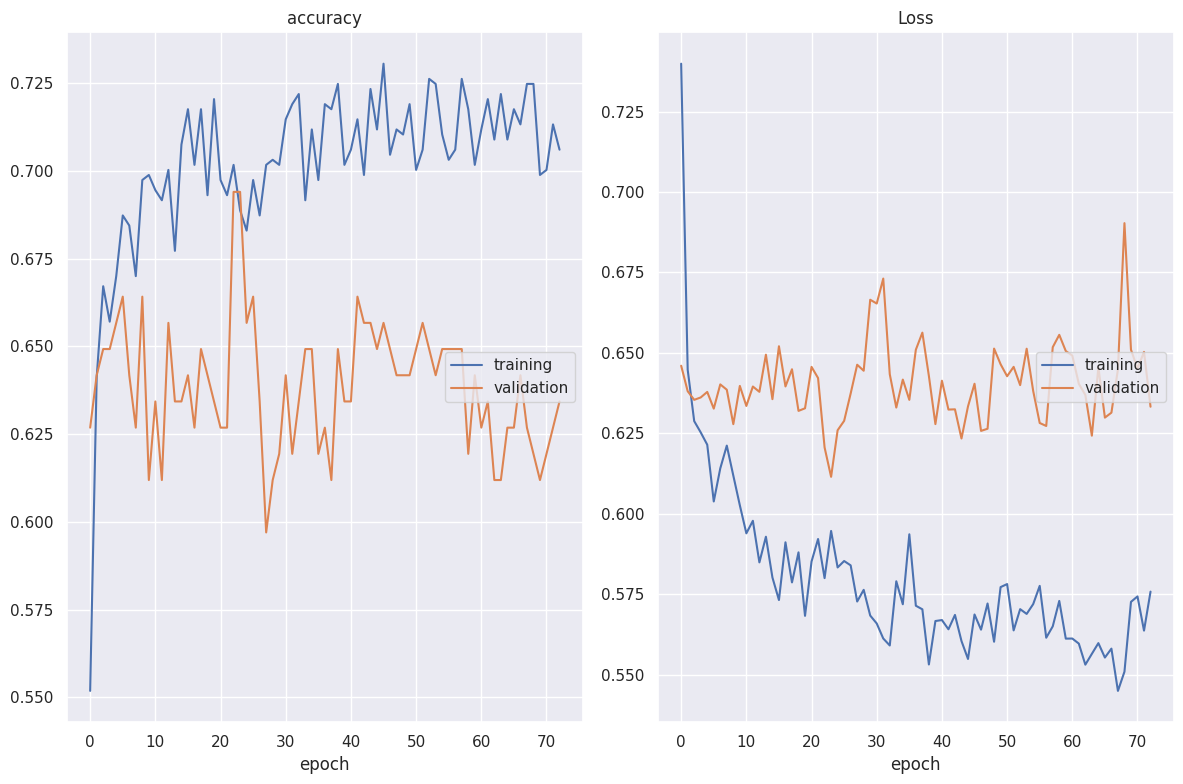

accuracy
	training         	 (min:    0.552, max:    0.731, cur:    0.706)
	validation       	 (min:    0.597, max:    0.694, cur:    0.634)
Loss
	training         	 (min:    0.545, max:    0.740, cur:    0.576)
	validation       	 (min:    0.611, max:    0.690, cur:    0.633)

Epoch 73: val_accuracy did not improve from 0.69403
70/70 [==============================] - 1s 11ms/step - loss: 0.5758 - accuracy: 0.7061 - val_loss: 0.6333 - val_accuracy: 0.6343


In [655]:
model_name = 'model_users_only_1000_1_v1_batch_size_10_epochs_200'
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=10, epochs=200)

#### Prediction and results

Accuracy: 0.6785714285714286
Precision: [0.64367816 0.73584906]
Recall: 0.5571428571428572
F1 score: 0.634146
ROC AUC: 0.678571


(0.6785714285714286,
 array([0.64367816, 0.73584906]),
 0.5571428571428572,
 0.6341463414634148,
 0.6785714285714286)

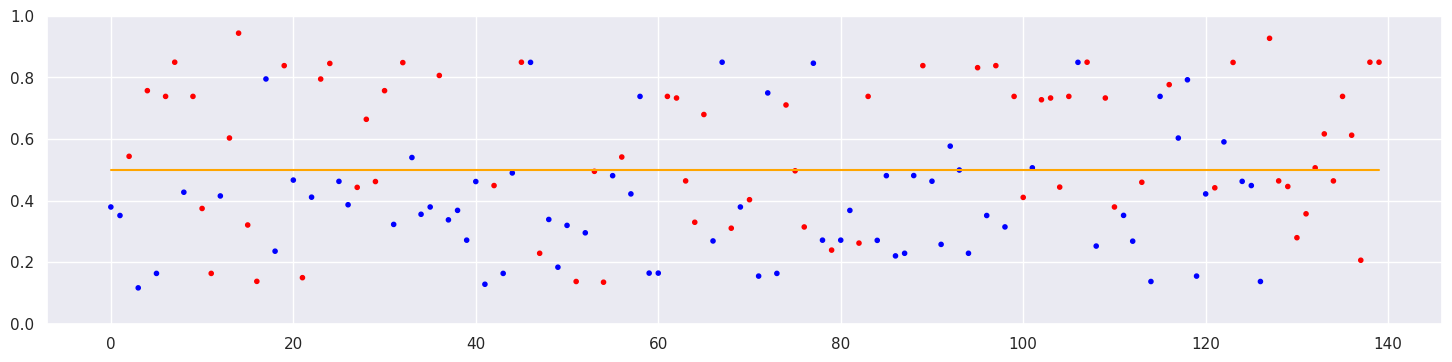

<Figure size 640x480 with 0 Axes>

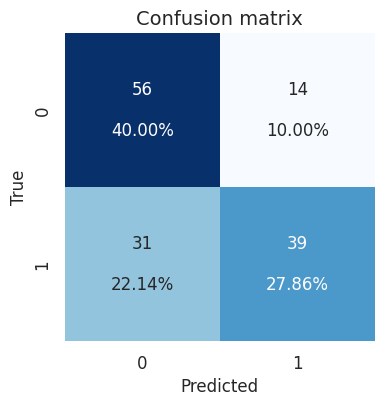

In [656]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### batch_size=50, epochs=200

In [657]:
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
print(model1_v1.summary())

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_115 (Dense)           (None, 32)                448       
                                                                 
 dense_116 (Dense)           (None, 32)                1056      
                                                                 
 dropout_46 (Dropout)        (None, 32)                0         
                                                                 
 dense_117 (Dense)           (None, 64)                2112      
                                                                 
 dense_118 (Dense)           (None, 64)                4160      
                                                                 
 dropout_47 (Dropout)        (None, 64)                0         
                                                                 
 dense_119 (Dense)           (None, 1)               

### Train model

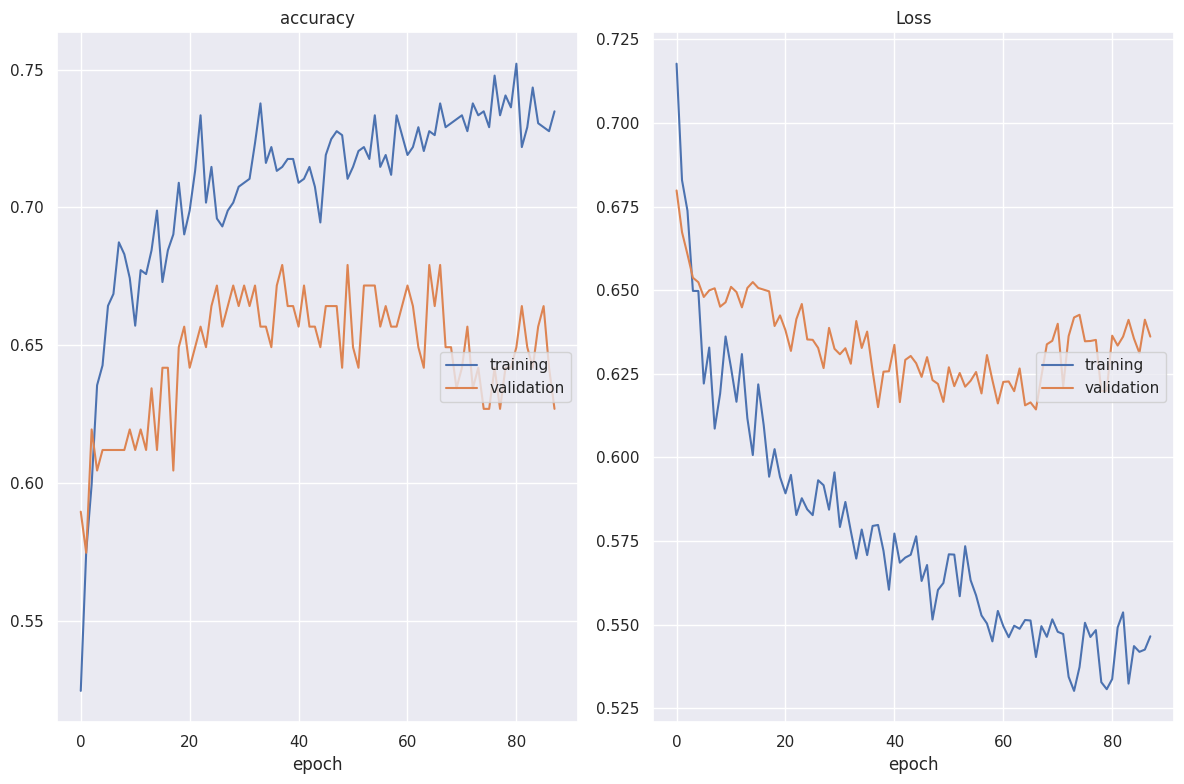

accuracy
	training         	 (min:    0.524, max:    0.752, cur:    0.735)
	validation       	 (min:    0.575, max:    0.679, cur:    0.627)
Loss
	training         	 (min:    0.530, max:    0.718, cur:    0.547)
	validation       	 (min:    0.614, max:    0.680, cur:    0.636)

Epoch 88: val_accuracy did not improve from 0.67910
14/14 [==============================] - 1s 43ms/step - loss: 0.5466 - accuracy: 0.7349 - val_loss: 0.6361 - val_accuracy: 0.6269


In [658]:
model_name = 'model_users_only_1000_1_v1_batch_size_50_epochs_200'
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=50, epochs=200)

In [659]:
# Load model
# model = load_model_from_file(models_path + '/model_name.hdf5')

#### Prediction

In [660]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

#### Results

(0.0, 1.0)

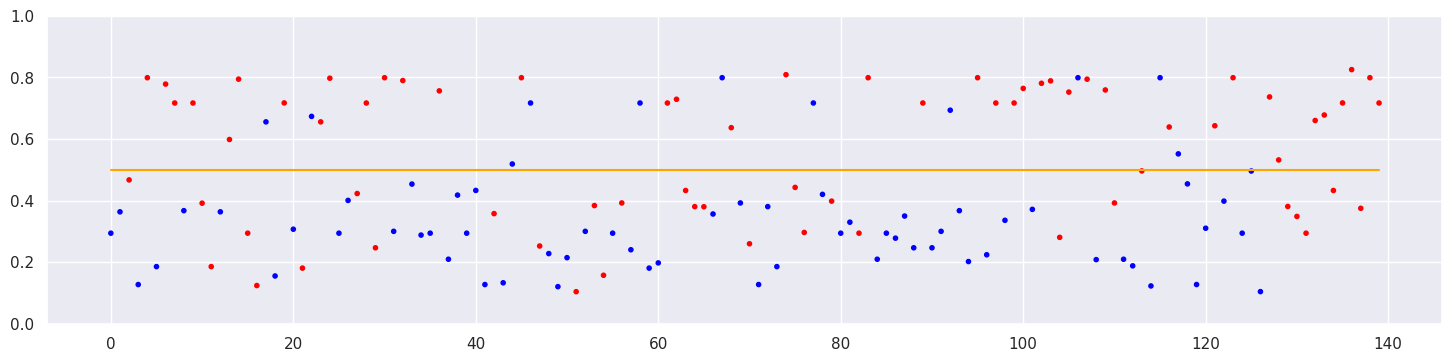

In [661]:
x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

#### Confusion matrix

Accuracy: 0.7071428571428572
Precision: [0.66292135 0.78431373]
Recall: 0.5714285714285714
F1 score: 0.661157
ROC AUC: 0.707143


(0.7071428571428572,
 array([0.66292135, 0.78431373]),
 0.5714285714285714,
 0.6611570247933883,
 0.7071428571428571)

<Figure size 640x480 with 0 Axes>

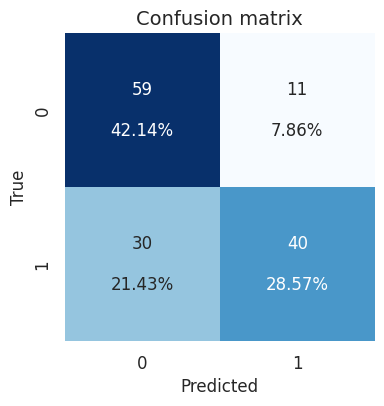

In [662]:
create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### batch_size=100, epochs=200

#### Create and train model

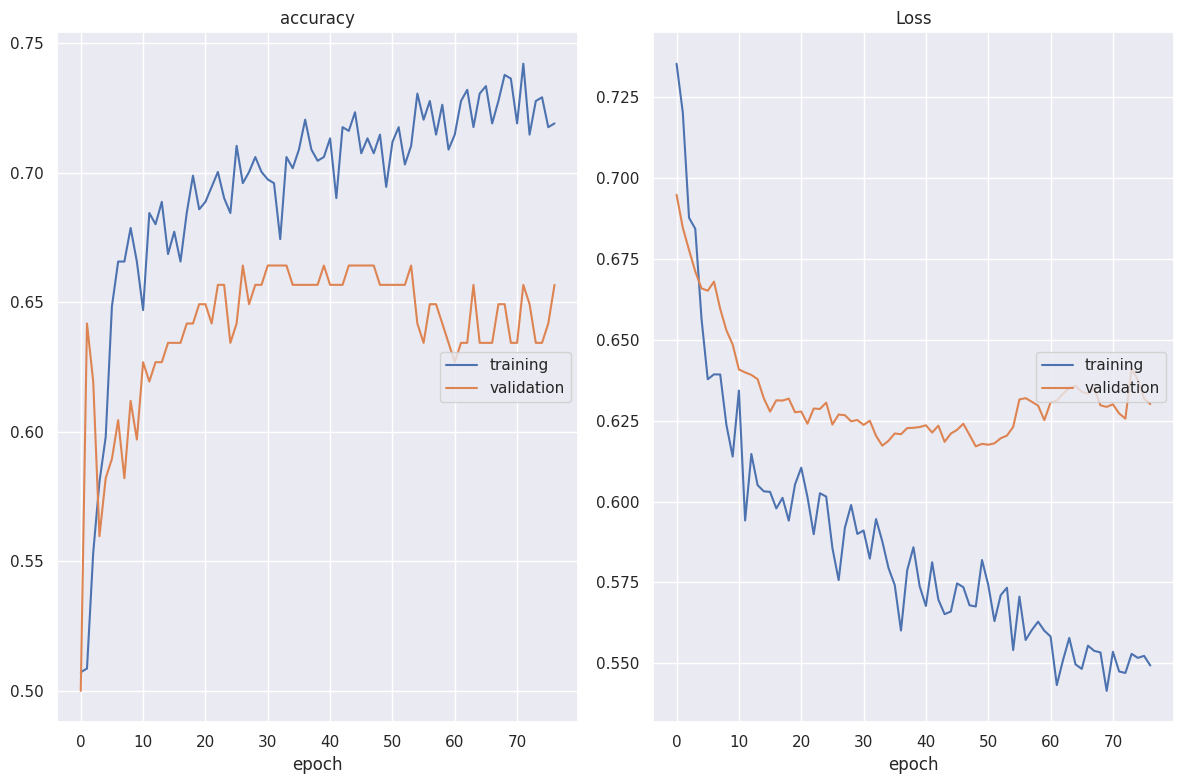

accuracy
	training         	 (min:    0.507, max:    0.742, cur:    0.719)
	validation       	 (min:    0.500, max:    0.664, cur:    0.657)
Loss
	training         	 (min:    0.541, max:    0.735, cur:    0.549)
	validation       	 (min:    0.617, max:    0.695, cur:    0.630)

Epoch 77: val_accuracy did not improve from 0.66418
7/7 [==============================] - 1s 99ms/step - loss: 0.5493 - accuracy: 0.7190 - val_loss: 0.6301 - val_accuracy: 0.6567


In [663]:
model_name = 'model_users_only_1000_1_v1_batch_size_100_epochs_200'
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=100, epochs=200)

#### Prediction and results

Accuracy: 0.7
Precision: [0.67073171 0.74137931]
Recall: 0.6142857142857143
F1 score: 0.671875
ROC AUC: 0.700000


(0.7, array([0.67073171, 0.74137931]), 0.6142857142857143, 0.671875, 0.7)

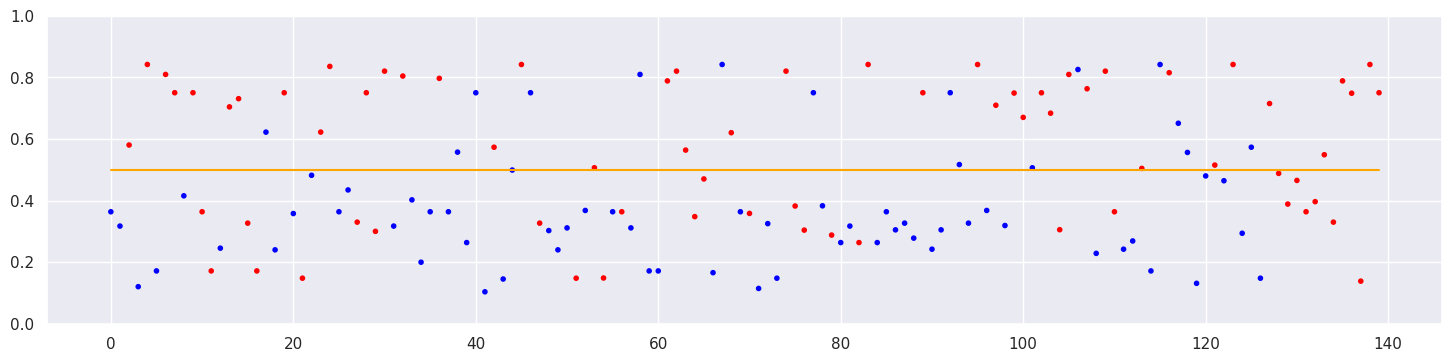

<Figure size 640x480 with 0 Axes>

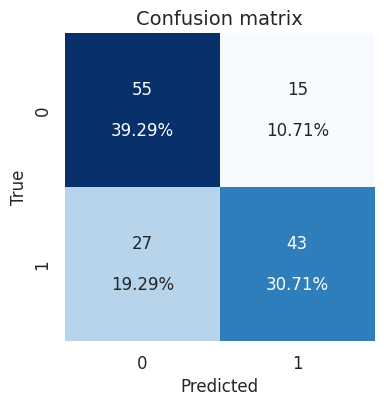

In [664]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### batch_size=150, epochs=200

#### Create and train model

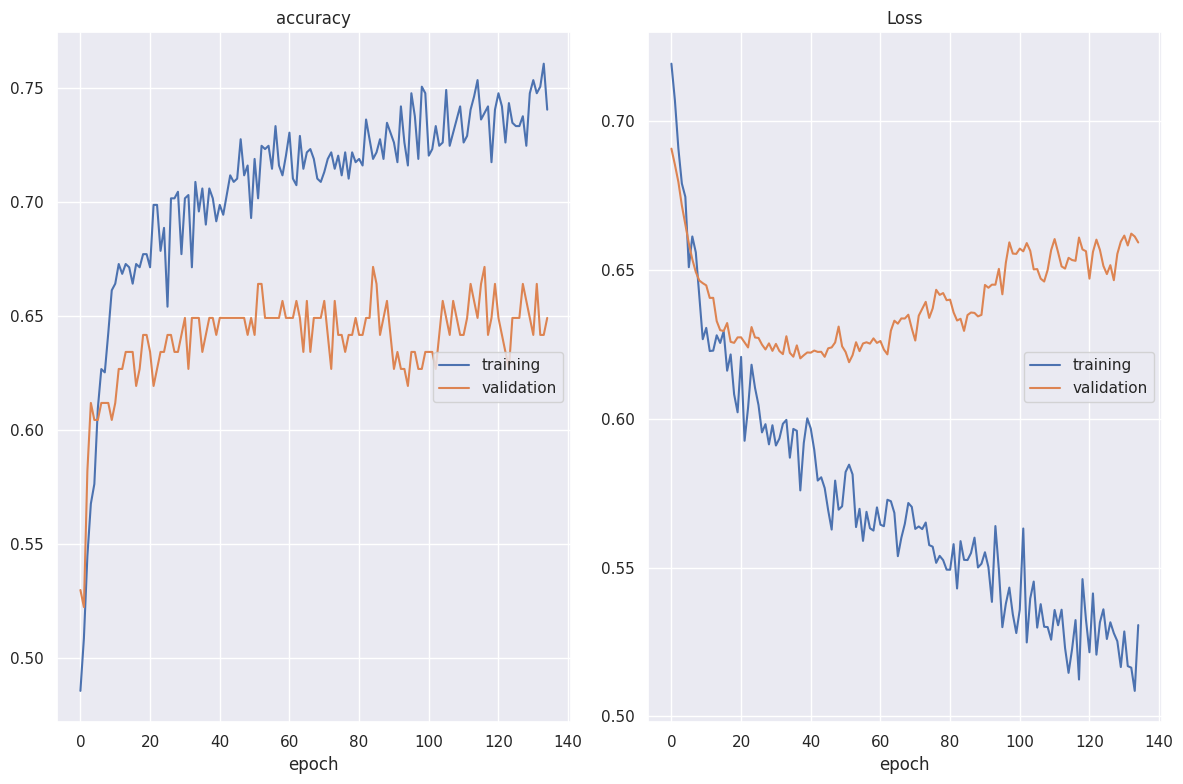

accuracy
	training         	 (min:    0.486, max:    0.761, cur:    0.741)
	validation       	 (min:    0.522, max:    0.672, cur:    0.649)
Loss
	training         	 (min:    0.509, max:    0.719, cur:    0.531)
	validation       	 (min:    0.619, max:    0.691, cur:    0.659)

Epoch 135: val_accuracy did not improve from 0.67164
5/5 [==============================] - 1s 144ms/step - loss: 0.5307 - accuracy: 0.7406 - val_loss: 0.6592 - val_accuracy: 0.6493


In [665]:
model_name = 'model_users_only_1000_1_v1_batch_size_150_epochs_200'
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=150, epochs=200)

#### Prediction and results

Accuracy: 0.7214285714285714
Precision: [0.69620253 0.75409836]
Recall: 0.6571428571428571
F1 score: 0.702290
ROC AUC: 0.721429


(0.7214285714285714,
 array([0.69620253, 0.75409836]),
 0.6571428571428571,
 0.7022900763358779,
 0.7214285714285713)

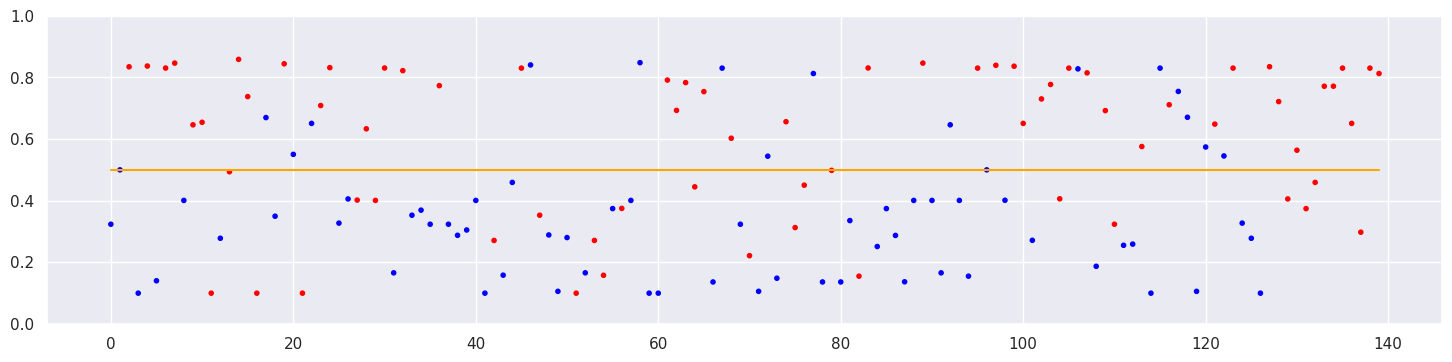

<Figure size 640x480 with 0 Axes>

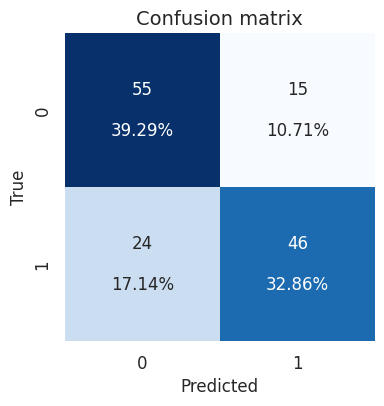

In [666]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### batch_size=200, epochs=200

#### Create and train model

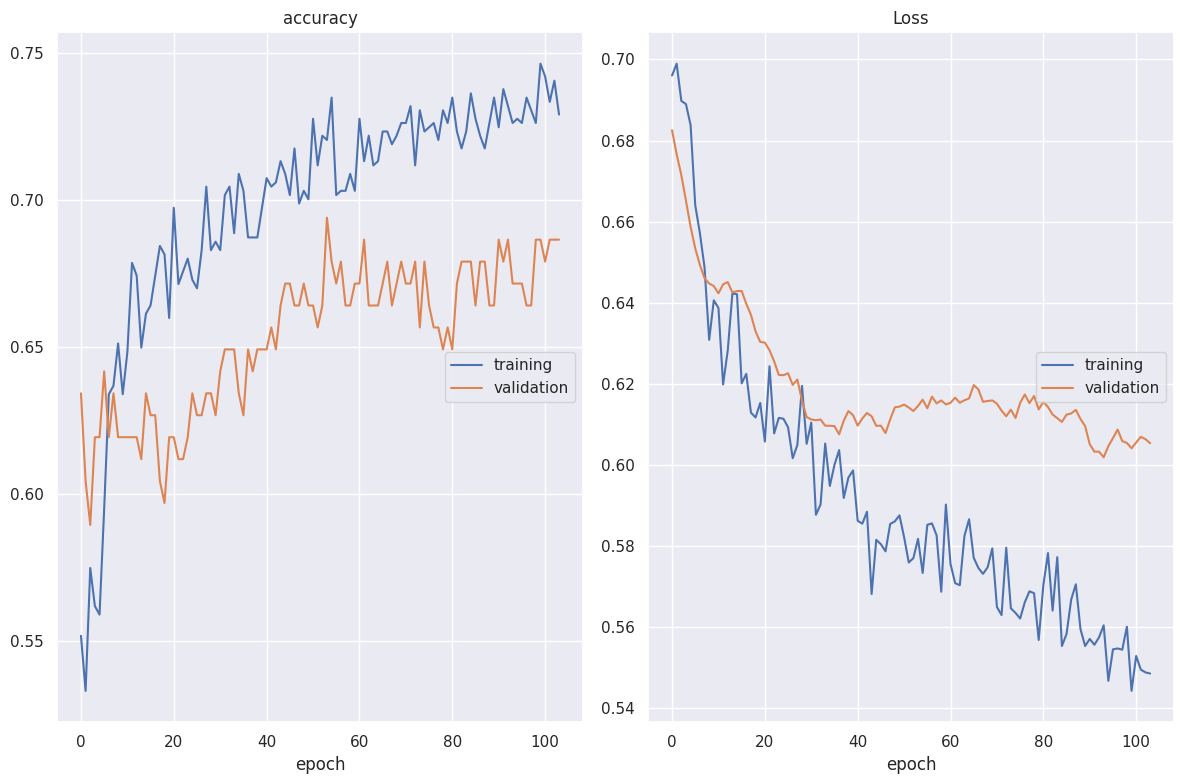

accuracy
	training         	 (min:    0.533, max:    0.746, cur:    0.729)
	validation       	 (min:    0.590, max:    0.694, cur:    0.687)
Loss
	training         	 (min:    0.544, max:    0.699, cur:    0.549)
	validation       	 (min:    0.602, max:    0.683, cur:    0.605)

Epoch 104: val_accuracy did not improve from 0.69403
4/4 [==============================] - 1s 183ms/step - loss: 0.5486 - accuracy: 0.7291 - val_loss: 0.6054 - val_accuracy: 0.6866


In [667]:
model_name = 'model_users_only_1000_1_v1_batch_size_200_epochs_200'
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=200, epochs=200)

#### Prediction and results

Accuracy: 0.6857142857142857
Precision: [0.65116279 0.74074074]
Recall: 0.5714285714285714
F1 score: 0.645161
ROC AUC: 0.685714


(0.6857142857142857,
 array([0.65116279, 0.74074074]),
 0.5714285714285714,
 0.6451612903225806,
 0.6857142857142857)

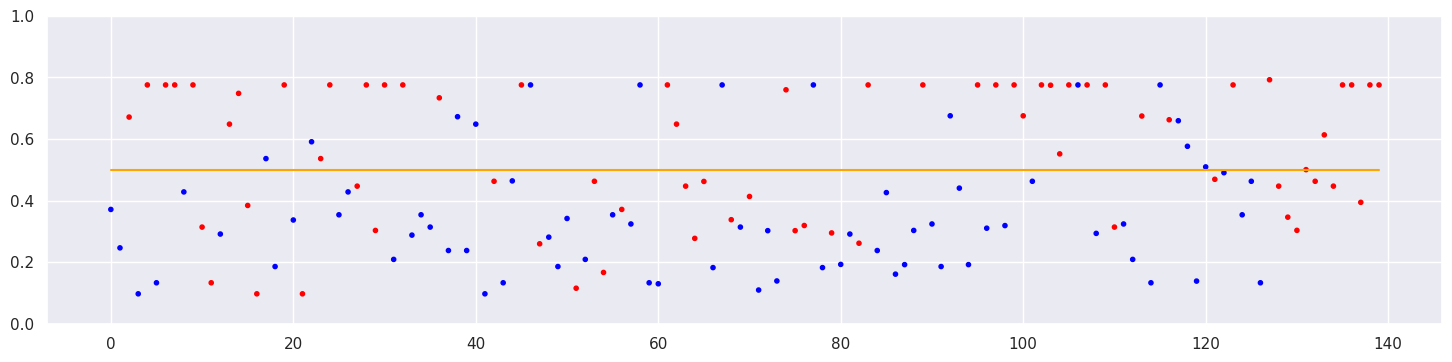

<Figure size 640x480 with 0 Axes>

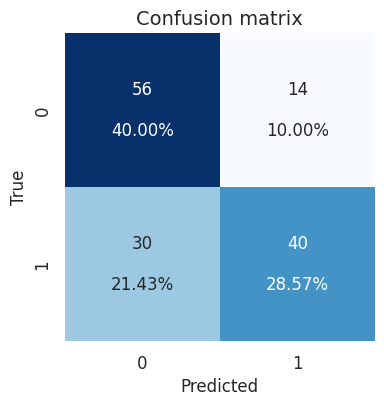

In [668]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### batch_size=250, epochs=200

#### Create and train model

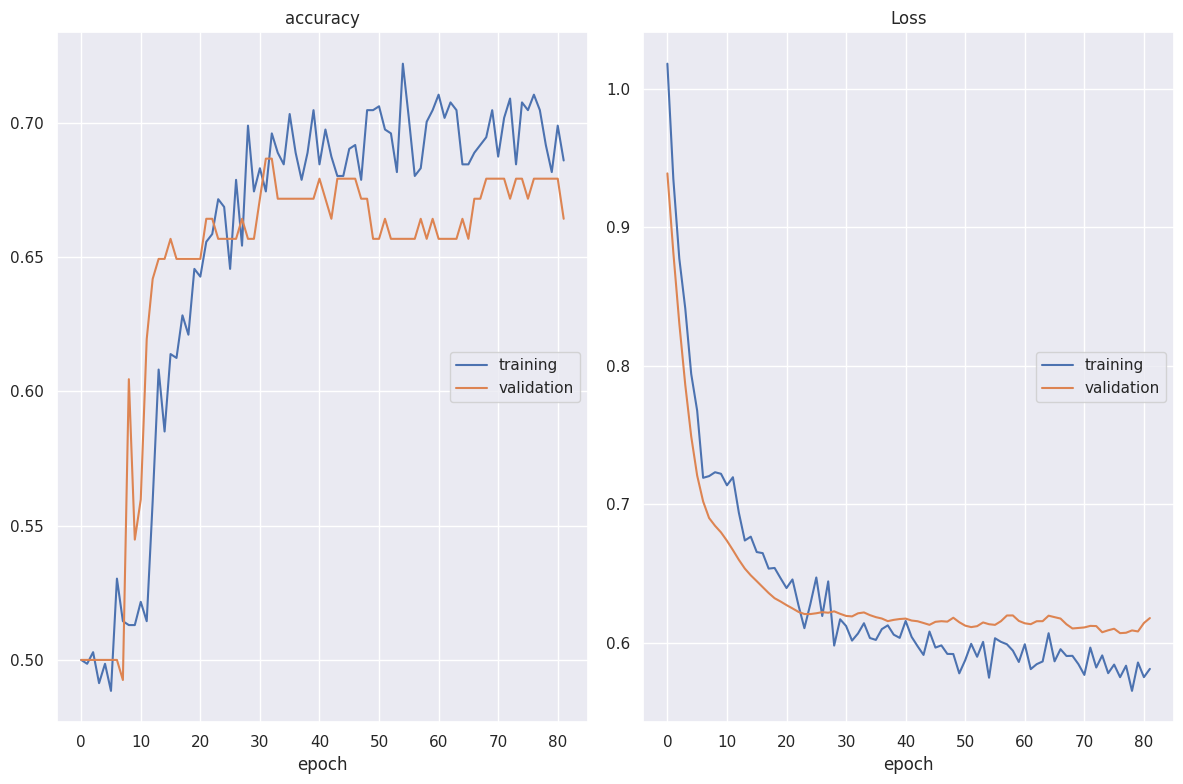

accuracy
	training         	 (min:    0.488, max:    0.722, cur:    0.686)
	validation       	 (min:    0.493, max:    0.687, cur:    0.664)
Loss
	training         	 (min:    0.565, max:    1.018, cur:    0.581)
	validation       	 (min:    0.607, max:    0.939, cur:    0.618)

Epoch 82: val_accuracy did not improve from 0.68657
3/3 [==============================] - 1s 298ms/step - loss: 0.5811 - accuracy: 0.6859 - val_loss: 0.6177 - val_accuracy: 0.6642


In [669]:
model_name = 'model_users_only_1000_1_v1_batch_size_250_epochs_200'
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=250, epochs=200)

#### Prediction and results

Accuracy: 0.7071428571428572
Precision: [0.68831169 0.73015873]
Recall: 0.6571428571428571
F1 score: 0.691729
ROC AUC: 0.707143


(0.7071428571428572,
 array([0.68831169, 0.73015873]),
 0.6571428571428571,
 0.6917293233082706,
 0.7071428571428571)

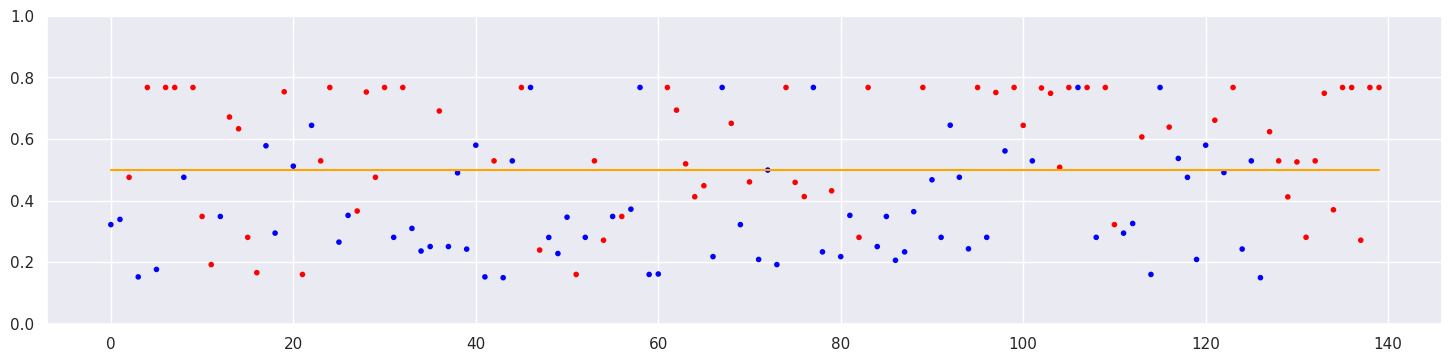

<Figure size 640x480 with 0 Axes>

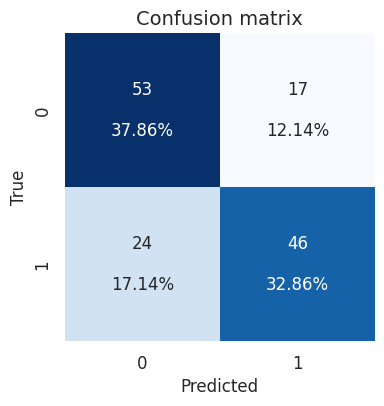

In [670]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### Model 1. - version for data reduced by outliers

### batch_size=10, epochs=200

#### Create and train model

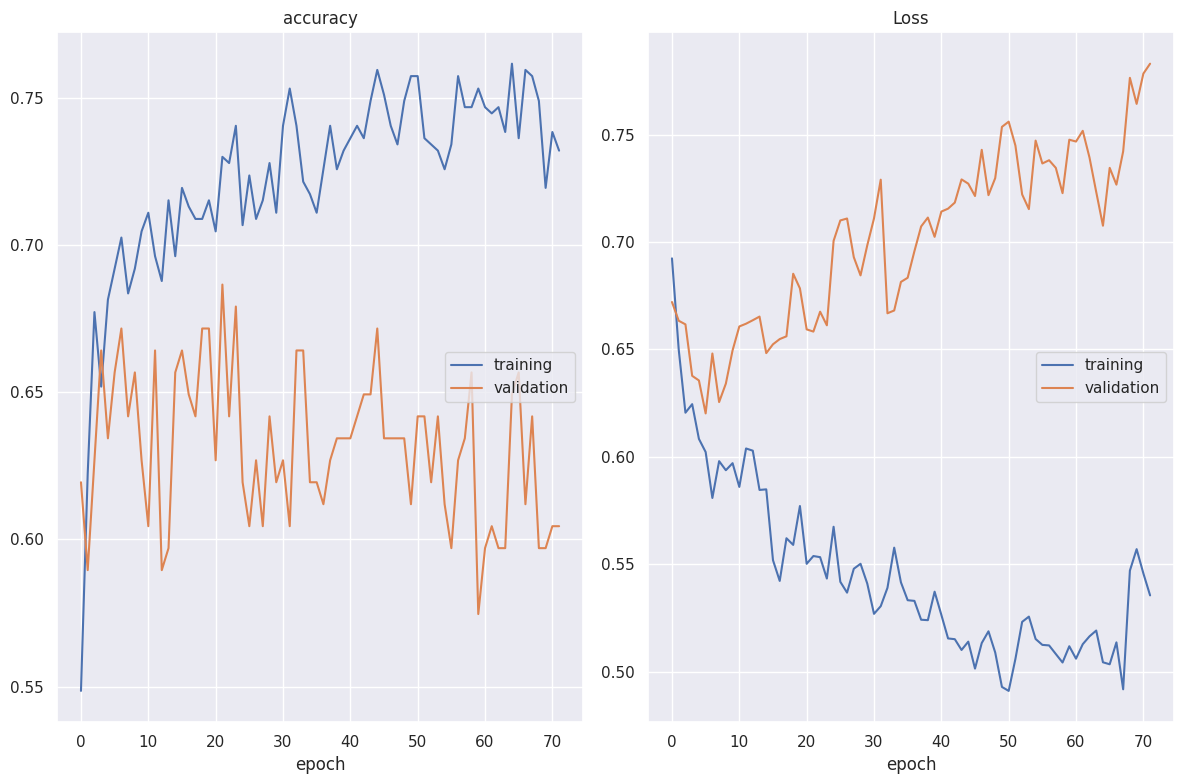

accuracy
	training         	 (min:    0.549, max:    0.762, cur:    0.732)
	validation       	 (min:    0.575, max:    0.687, cur:    0.604)
Loss
	training         	 (min:    0.491, max:    0.692, cur:    0.536)
	validation       	 (min:    0.620, max:    0.783, cur:    0.783)

Epoch 72: val_accuracy did not improve from 0.68657
48/48 [==============================] - 1s 15ms/step - loss: 0.5355 - accuracy: 0.7321 - val_loss: 0.7830 - val_accuracy: 0.6045


In [671]:
model_name = 'model_users_only_1000_1_v2_wo_outliers_batch_size_10_epochs_200'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=10, epochs=200)

#### Prediction and results

Accuracy: 0.7071428571428572
Precision: [0.65934066 0.79591837]
Recall: 0.5571428571428572
F1 score: 0.655462
ROC AUC: 0.707143


(0.7071428571428572,
 array([0.65934066, 0.79591837]),
 0.5571428571428572,
 0.6554621848739496,
 0.7071428571428572)

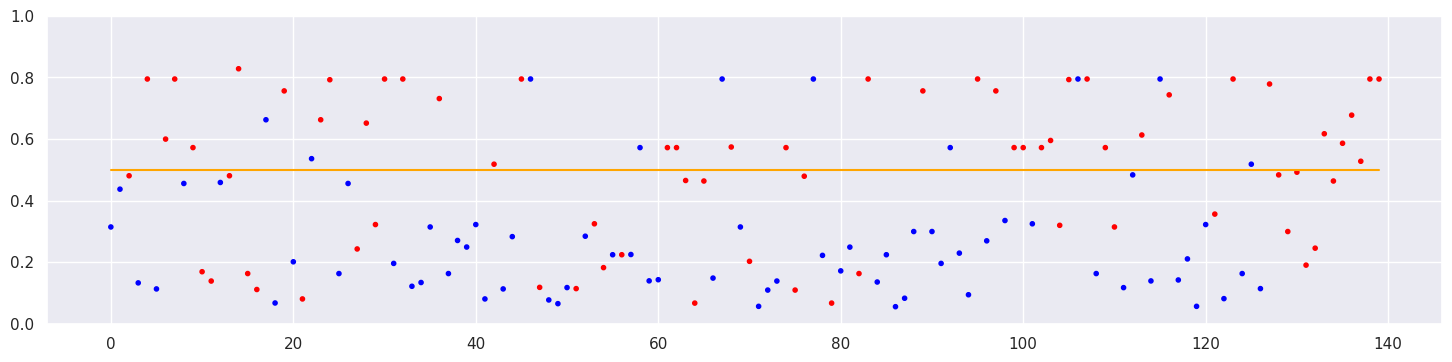

<Figure size 640x480 with 0 Axes>

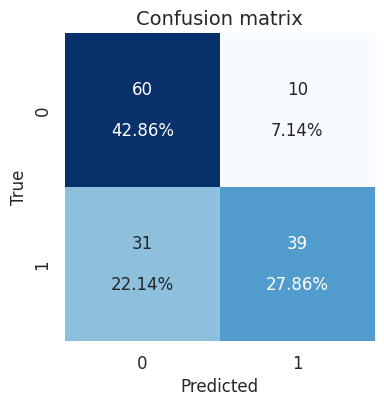

In [672]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)

### batch_size=50, epochs=200

#### Create and train model

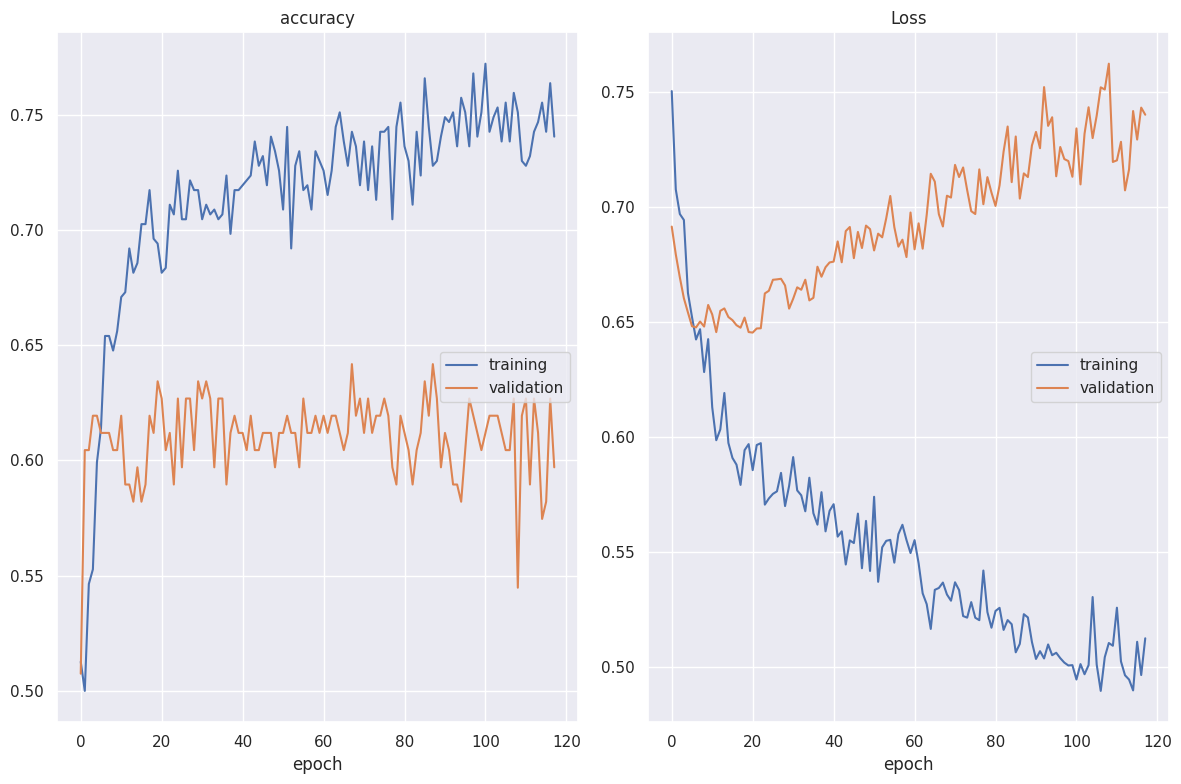

accuracy
	training         	 (min:    0.500, max:    0.772, cur:    0.741)
	validation       	 (min:    0.507, max:    0.642, cur:    0.597)
Loss
	training         	 (min:    0.490, max:    0.751, cur:    0.513)
	validation       	 (min:    0.646, max:    0.763, cur:    0.740)

Epoch 118: val_accuracy did not improve from 0.64179
10/10 [==============================] - 1s 73ms/step - loss: 0.5126 - accuracy: 0.7405 - val_loss: 0.7403 - val_accuracy: 0.5970


In [673]:
model_name = 'model_users_only_1000_1_v2_wo_outliers_batch_size_50_epochs_200'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=50, epochs=200)

#### Prediction and results

Accuracy: 0.6857142857142857
Precision: [0.64772727 0.75      ]
Recall: 0.5571428571428572
F1 score: 0.639344
ROC AUC: 0.685714


(0.6857142857142857,
 array([0.64772727, 0.75      ]),
 0.5571428571428572,
 0.639344262295082,
 0.6857142857142857)

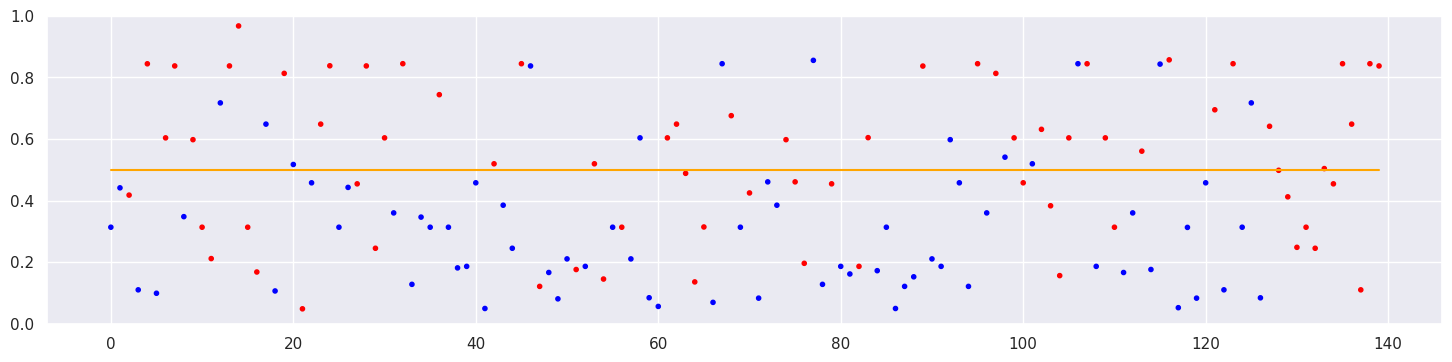

<Figure size 640x480 with 0 Axes>

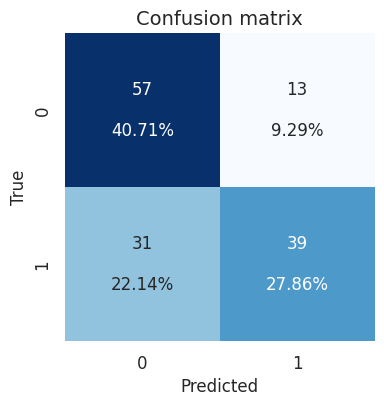

In [674]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)

### batch_size=100, epochs=200

#### Create and train model

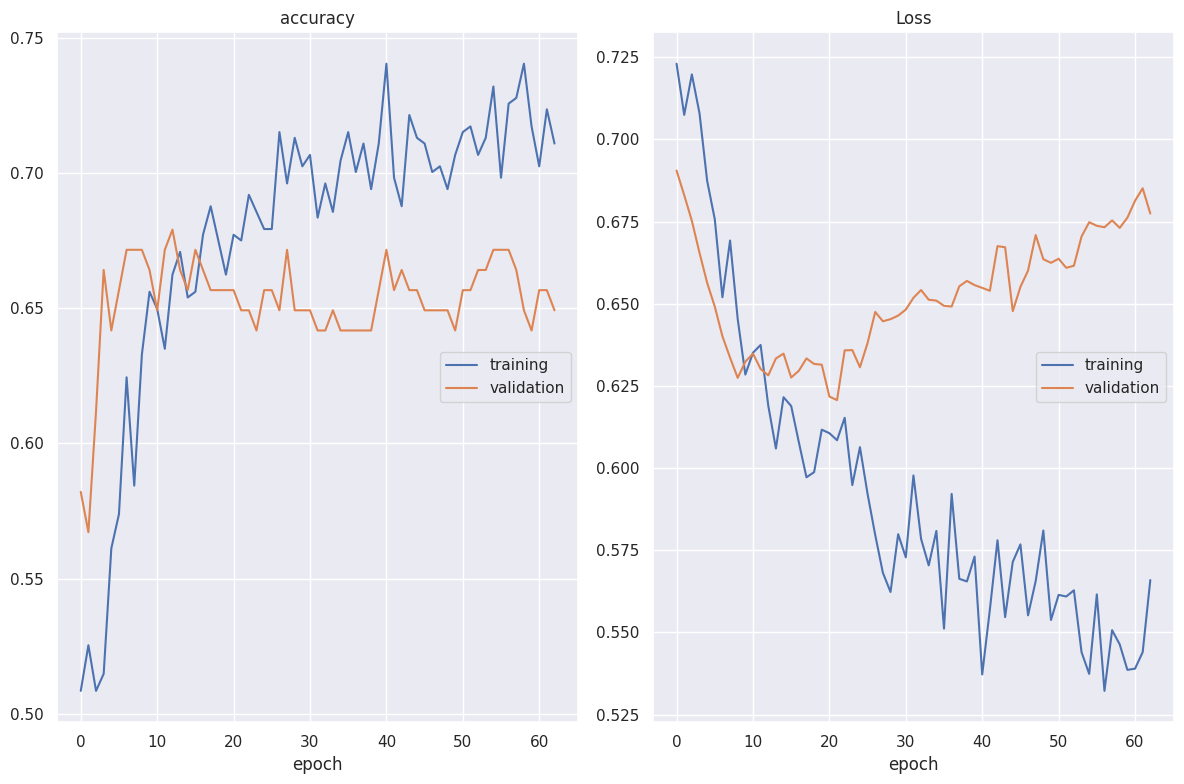

accuracy
	training         	 (min:    0.508, max:    0.741, cur:    0.711)
	validation       	 (min:    0.567, max:    0.679, cur:    0.649)
Loss
	training         	 (min:    0.532, max:    0.723, cur:    0.566)
	validation       	 (min:    0.621, max:    0.691, cur:    0.677)

Epoch 63: val_accuracy did not improve from 0.67910
5/5 [==============================] - 1s 144ms/step - loss: 0.5659 - accuracy: 0.7110 - val_loss: 0.6775 - val_accuracy: 0.6493


In [675]:
model_name = 'model_users_only_1000_1_v2_wo_outliers_batch_size_100_epochs_200'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=100, epochs=200)

#### Prediction and results

Accuracy: 0.6785714285714286
Precision: [0.65060241 0.71929825]
Recall: 0.5857142857142857
F1 score: 0.645669
ROC AUC: 0.678571


(0.6785714285714286,
 array([0.65060241, 0.71929825]),
 0.5857142857142857,
 0.6456692913385826,
 0.6785714285714287)

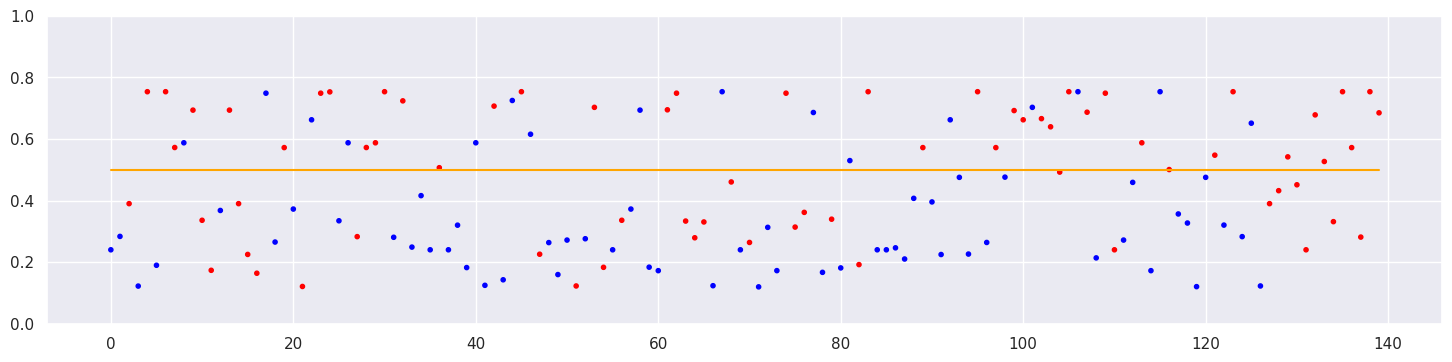

<Figure size 640x480 with 0 Axes>

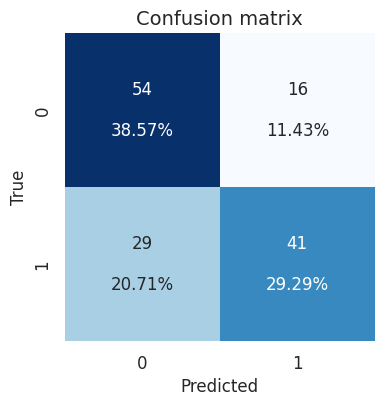

In [676]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)

### batch_size=150, epochs=200

#### Create and train model

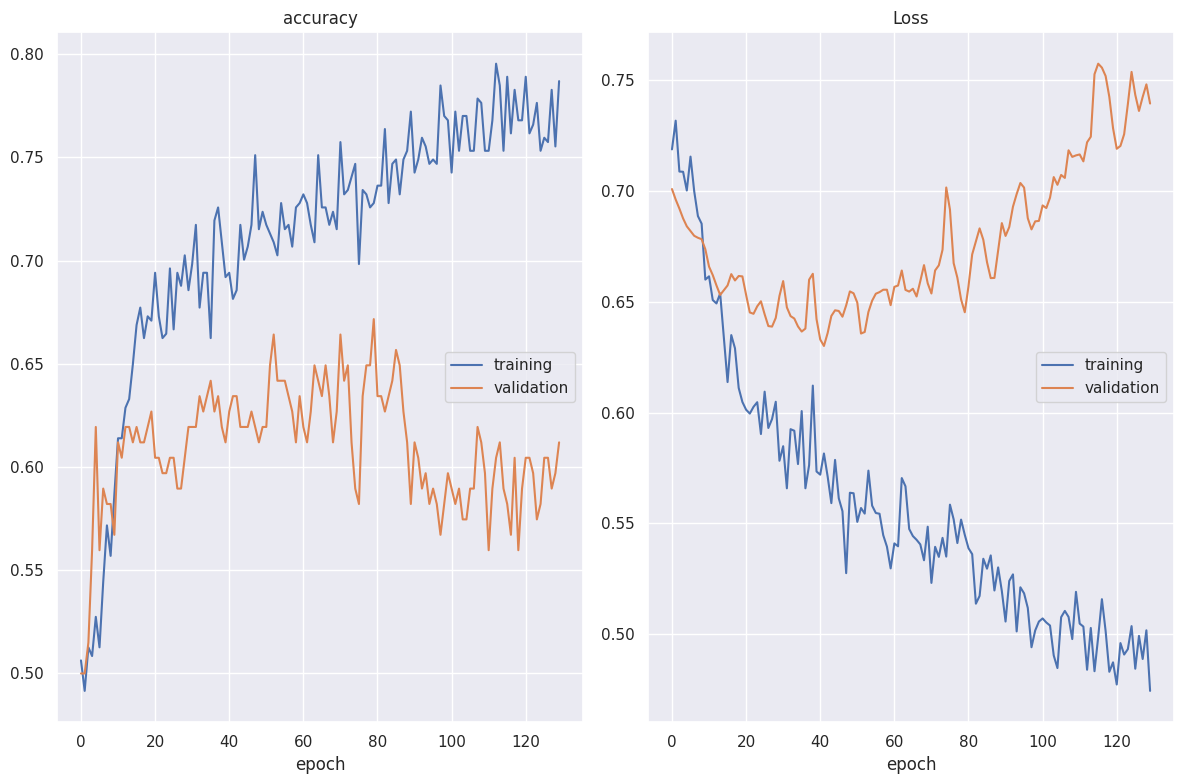

accuracy
	training         	 (min:    0.492, max:    0.795, cur:    0.787)
	validation       	 (min:    0.500, max:    0.672, cur:    0.612)
Loss
	training         	 (min:    0.474, max:    0.732, cur:    0.474)
	validation       	 (min:    0.630, max:    0.758, cur:    0.740)

Epoch 130: val_accuracy did not improve from 0.67164
4/4 [==============================] - 1s 189ms/step - loss: 0.4743 - accuracy: 0.7869 - val_loss: 0.7396 - val_accuracy: 0.6119


In [677]:
model_name = 'model_users_only_1000_1_v2_wo_outliers_batch_size_150_epochs_200'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=150, epochs=200)

#### Prediction and results

Accuracy: 0.7357142857142858
Precision: [0.69879518 0.78947368]
Recall: 0.6428571428571429
F1 score: 0.708661
ROC AUC: 0.735714


(0.7357142857142858,
 array([0.69879518, 0.78947368]),
 0.6428571428571429,
 0.7086614173228346,
 0.7357142857142857)

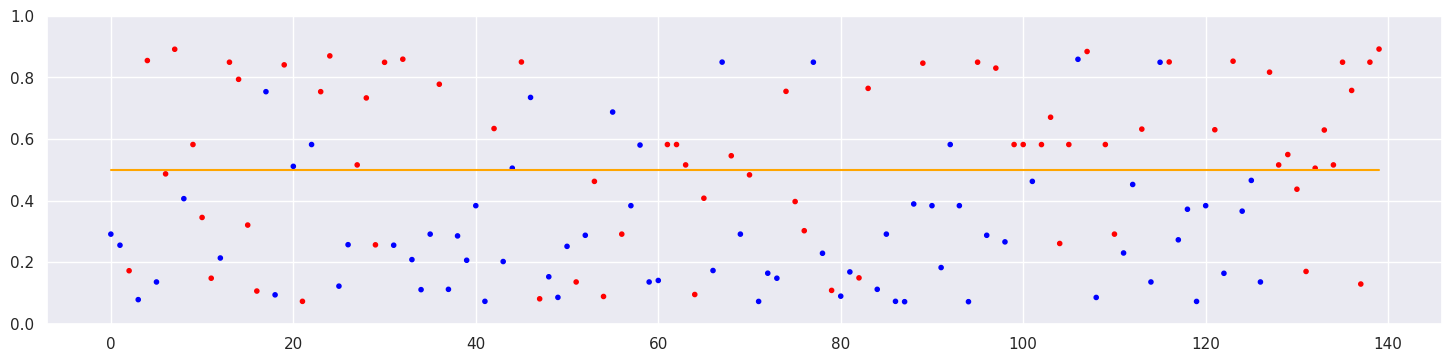

<Figure size 640x480 with 0 Axes>

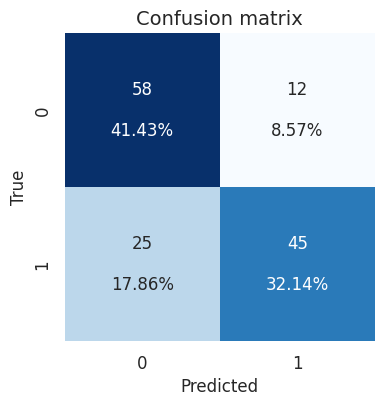

In [678]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)

### batch_size=200, epochs=200

#### Create and train model

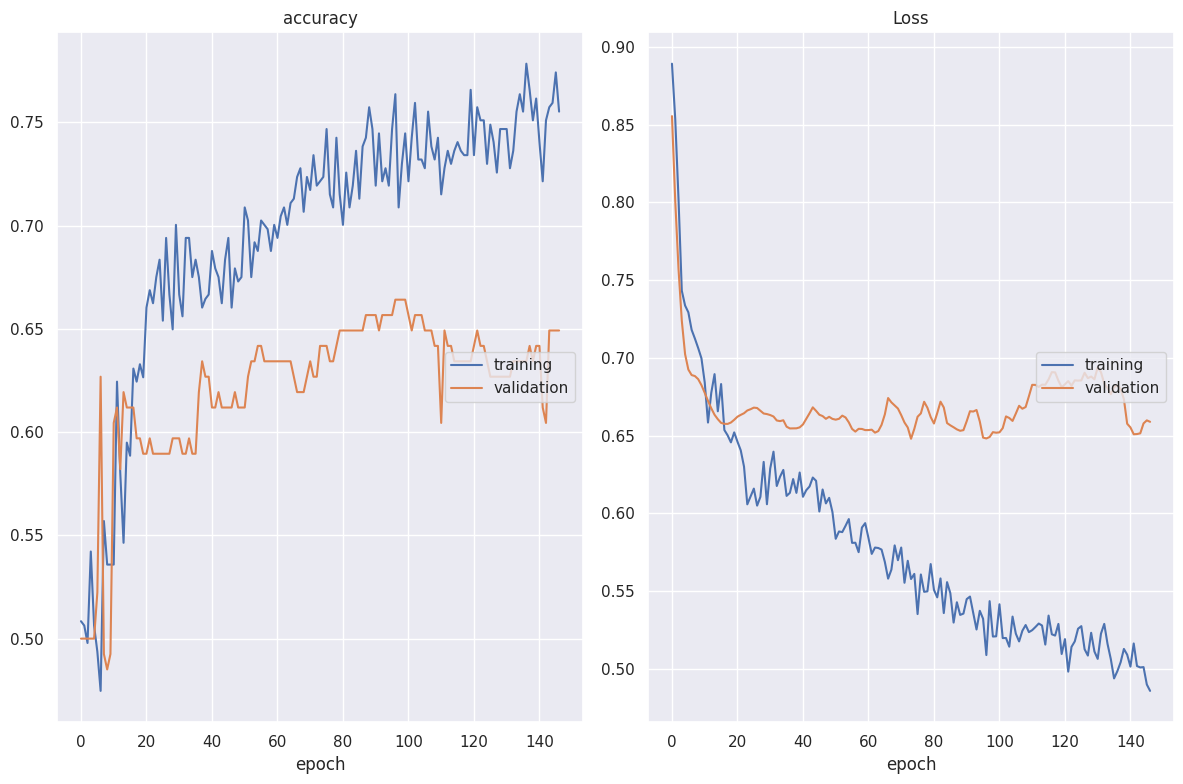

accuracy
	training         	 (min:    0.475, max:    0.778, cur:    0.755)
	validation       	 (min:    0.485, max:    0.664, cur:    0.649)
Loss
	training         	 (min:    0.486, max:    0.889, cur:    0.486)
	validation       	 (min:    0.648, max:    0.856, cur:    0.659)

Epoch 147: val_accuracy did not improve from 0.66418
3/3 [==============================] - 1s 287ms/step - loss: 0.4857 - accuracy: 0.7553 - val_loss: 0.6588 - val_accuracy: 0.6493


In [679]:
model_name = 'model_users_only_1000_1_v2_wo_outliers_batch_size_200_epochs_200'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=200, epochs=200)

#### Prediction and results

Accuracy: 0.7142857142857143
Precision: [0.68292683 0.75862069]
Recall: 0.6285714285714286
F1 score: 0.687500
ROC AUC: 0.714286


(0.7142857142857143,
 array([0.68292683, 0.75862069]),
 0.6285714285714286,
 0.6875,
 0.7142857142857143)

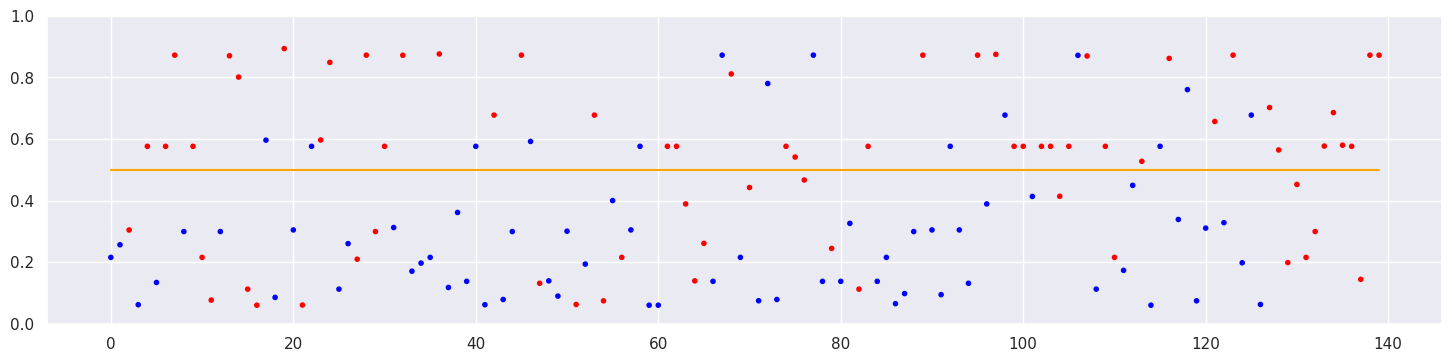

<Figure size 640x480 with 0 Axes>

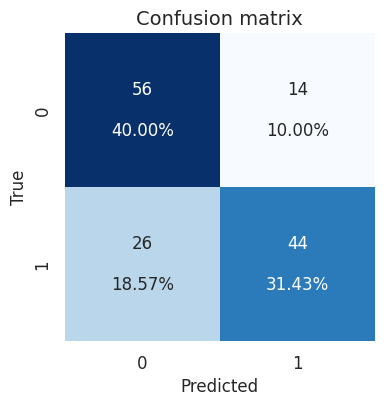

In [680]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)

### batch_size=250, epochs=200

#### Create and train model

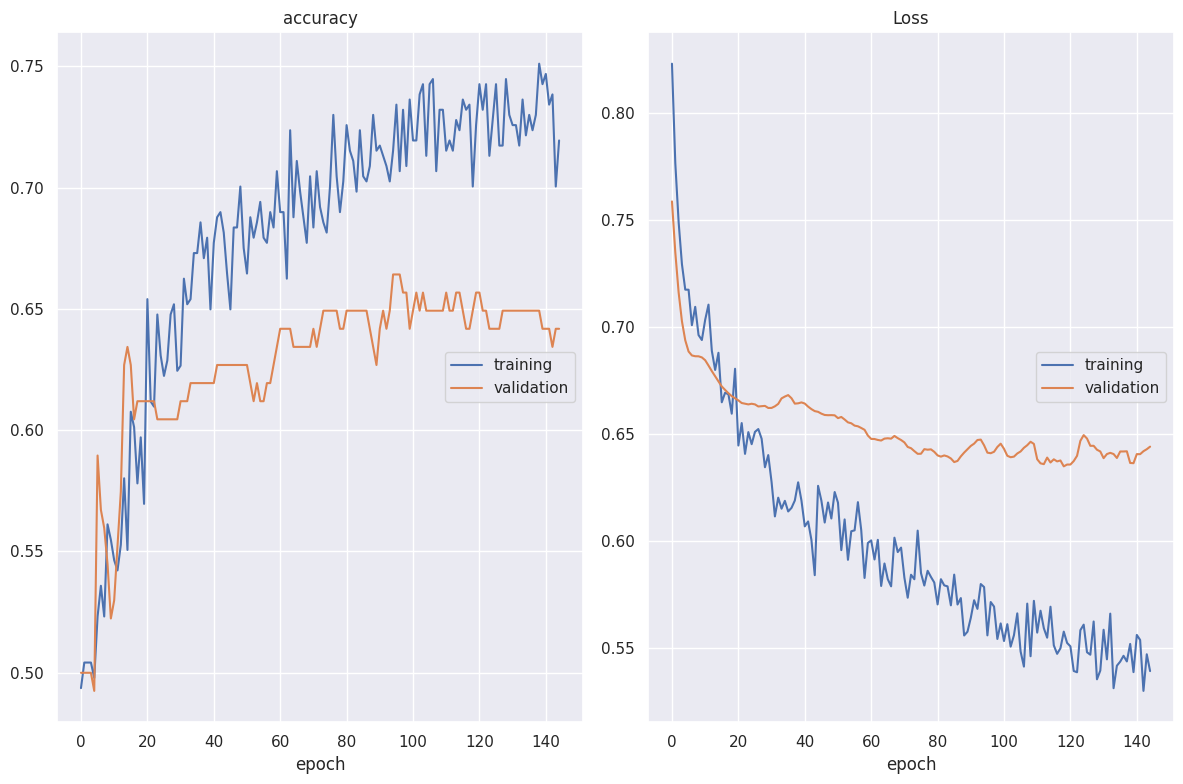

accuracy
	training         	 (min:    0.494, max:    0.751, cur:    0.719)
	validation       	 (min:    0.493, max:    0.664, cur:    0.642)
Loss
	training         	 (min:    0.530, max:    0.823, cur:    0.539)
	validation       	 (min:    0.635, max:    0.759, cur:    0.644)

Epoch 145: val_accuracy did not improve from 0.66418
2/2 [==============================] - 1s 576ms/step - loss: 0.5392 - accuracy: 0.7194 - val_loss: 0.6440 - val_accuracy: 0.6418


In [681]:
model_name = 'model_users_only_1000_1_v2_wo_outliers_batch_size_250_epochs_200'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=250, epochs=200)

#### Prediction and results

Accuracy: 0.7285714285714285
Precision: [0.68604651 0.7962963 ]
Recall: 0.6142857142857143
F1 score: 0.693548
ROC AUC: 0.728571


(0.7285714285714285,
 array([0.68604651, 0.7962963 ]),
 0.6142857142857143,
 0.6935483870967742,
 0.7285714285714285)

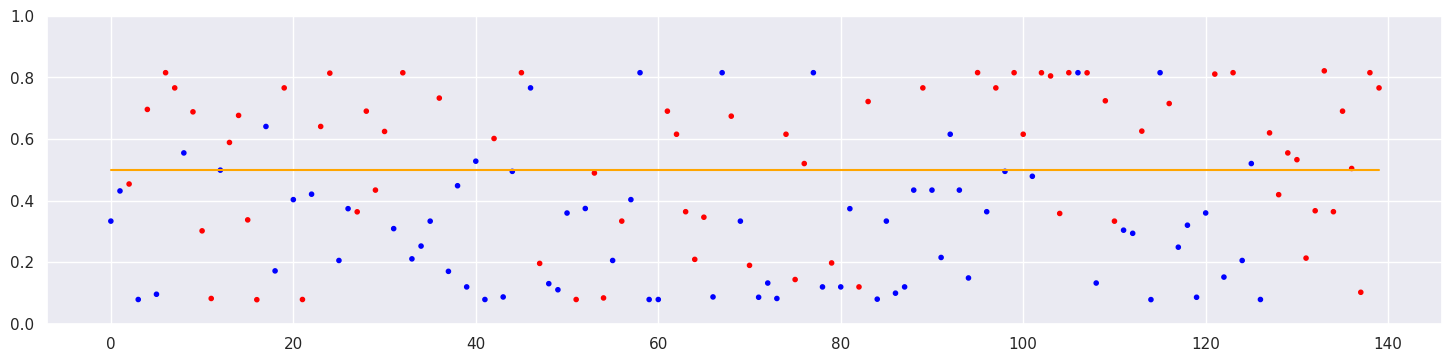

<Figure size 640x480 with 0 Axes>

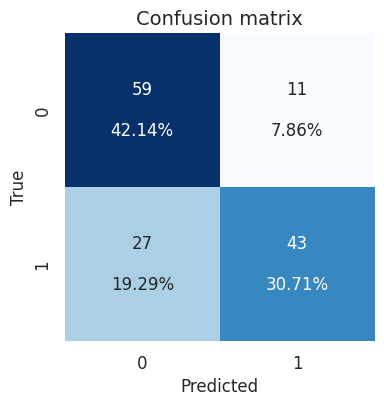

In [682]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)

## SHAP (SHapley Additive exPlanations) - done for model 1 v1

In [683]:
shape = (train_X.shape[1],)
model = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())

In [684]:
explainer = shap.DeepExplainer(model, np.asarray(train_X))
shap_values = explainer.shap_values(np.asarray(train_X))

/opt/conda/lib/python3.7/site-packages/shap/explainers/_deep/deep_tf.py:107: UserWarning:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.

/home/jupyter/.local/lib/python3.7/site-packages/keras/backend.py:452: UserWarning:

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.



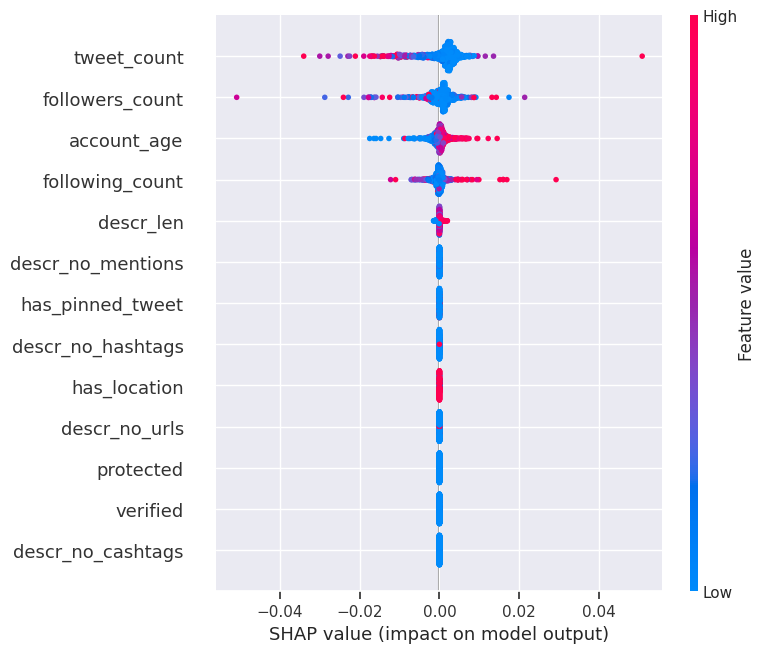

In [685]:
shap.summary_plot(shap_values[0], train_X, plot_type='dot')

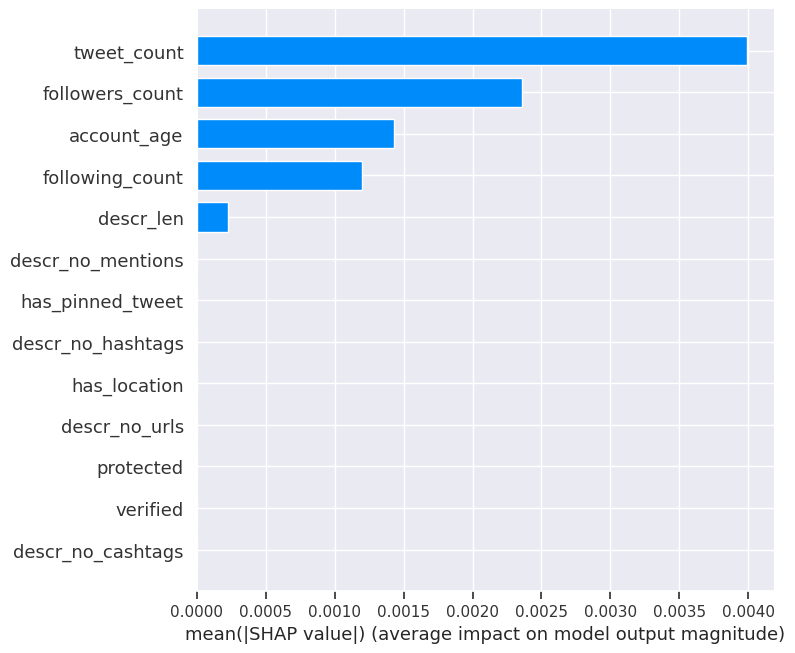

In [686]:
shap.summary_plot(shap_values[0], train_X, plot_type='bar')

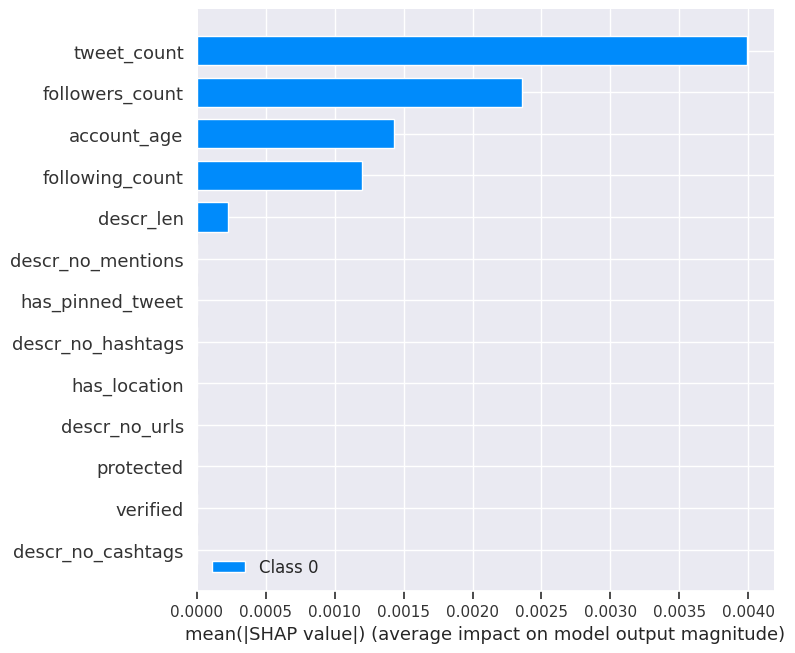

In [687]:
shap.summary_plot(shap_values, train_X, plot_type='bar')

In [688]:
# shap.dependence_plot("followers_count", shap_values[0],  train_X)

### Grid search for finding the most optimal set of parameters

In [689]:
# from sklearn.model_selection import GridSearchCV
# from scikeras.wrappers import KerasClassifier

In [690]:
# model_wrapper = KerasClassifier(model=create_model_1(shape=(train_X.shape[1],)))
# # model_wrapper.get_params().keys()

# early_stop_sg = EarlyStopping(monitor='accuracy',
#                            patience=50,
#                            restore_best_weights=True,
#                            mode='max')

# parameters = {
#     'optimizer' : [tf.keras.optimizers.Adam(learning_rate=0.0001), tf.keras.optimizers.Adam(learning_rate=0.001), tf.keras.optimizers.Adam(learning_rate=0.01)],
#     'batch_size' : [10, 20, 40, 60, 80, 100, 150, 200, 250],
#     'epochs' : [10, 50, 100],
#     'callbacks' : [early_stop_sg]}
# # parameters = {
# #     'batch_size' : [10, 20, 60, 100, 150, 200],
# #     'epochs' : [10, 50]}


# dnn_model_grid = GridSearchCV(estimator=model_wrapper,
#                         param_grid=parameters,
#                         scoring='accuracy',
#                         cv=5,
#                         n_jobs=10,
#                         verbose=0)


# dnn_model_grid.fit(train_X, train_Y)

In [691]:
# print("Best score: ", dnn_model_grid.best_score_)
# print("Best params: ", dnn_model_grid.best_params_)